# Table of contents

* [1. Datasets import](#import)
* [2. Data Exploration](#exploration)
  * [2.1 Numerical Features](#num)
  * [2.2 Categorical Features](#cat)
* [3. Preprocessing steps](#preprocessing)
  * [3.1. Incoherences](#incoherences)
  * [3.2. Outliers](#outliers)
  * [3.3. Missing Values](#miss)
  * [3.4. Feature Engineering](#feature_eng)
  * [3.5. Encoding and Grouping](#enc)
  * [3.6. Scaling](#scaling)
  * [3.7. Split and UnderSmapler](#us)
  * [3.8. Feature selection](#fselection)
    * [3.8.1. Filter methods](#filter)
        * [3.8.1.1 Univariate variables](#univariate)
        * [3.8.1.2. Chi-squared for categorical variables](#chi2)
        * [3.8.1.3. Mutual information](#mutual_info)
        * [3.8.1.4. Spearman Correlation](#spearman)
    * [3.8.2. Wrapper methods - RFE](#rfe)
    * [3.8.3. Embedded methods - Lasso](#lasso)
    * [3.8.4. Embedded methods - DecisionTree](#dt)
* [4. Model Selection and Evaluation](#model_selection)
* [5. Models Fine Tuning](#finetuning)
  * [6.1. Logistic Regression](#lr)
  * [6.2. Gradient Boosting](#gb)
  * [6.3. Random Forest](#rf)
  * [6.4. SVM](#svm)
  * [6.5. VotingClassifier](#VC)
* [7. Predictions for the test data](#testpredictions)

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basics
import pandas as pd
import numpy as np
import ast
from scipy.stats import uniform, randint, chi2_contingency
from collections import Counter

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Preporcessing
from sklearn.preprocessing import MinMaxScaler

# Model split and sampler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Feature Selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.linear_model import LassoCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation and parameter search
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.model_selection import cross_validate,cross_val_score, cross_val_predict, KFold, RepeatedKFold,GridSearchCV,RandomizedSearchCV

# Datasets import <a class="anchor" id="import"></a>

In [2]:
df_train = pd.read_csv('train.csv',
                 sep=',',
               index_col = ['encounter_id'],
                 na_values=['?']
                )

In [3]:
df_test = pd.read_csv('test.csv',
                 sep=',',
                 index_col = ['encounter_id'],
                 na_values=['?']
                )

# Data Exploration <a class="anchor" id="exploration"></a>

In [4]:
train = df_train.copy()
test = df_test.copy()

In [5]:
train.shape

(71236, 30)

In [6]:
test.shape

(30530, 28)

In [7]:
train.head(50).T

encounter_id,533253,426224,634063,890610,654194,269878,182051,964239,418598,760130,...,488420,315879,101519,224701,471683,469306,201542,806395,942220,810223
country,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA,...,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA
patient_id,70110,29775006,80729253,2919042,84871971,279288,1566405,60052095,85756257,96104214,...,40852710,1385559,73247976,84376332,86280993,89413974,98584524,3360294,98754759,2486844
race,Caucasian,AfricanAmerican,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Other,Caucasian,Caucasian,...,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Other,AfricanAmerican,Caucasian,AfricanAmerican
gender,Female,Male,Female,Male,Female,Female,Female,Male,Female,Female,...,Male,Male,Female,Male,Male,Female,Male,Female,Female,Female
age,[70-80),[50-60),[60-70),[60-70),[70-80),[50-60),[50-60),[70-80),[50-60),[70-80),...,[70-80),[60-70),[40-50),[70-80),[70-80),[60-70),[50-60),[30-40),[30-40),[30-40)
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payer_code,NaN,NaN,NaN,MC,HM,NaN,UN,MC,MC,MC,...,MC,NaN,MD,MC,MC,SP,SP,NaN,UN,NaN
outpatient_visits_in_previous_year,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,1,0,0,0,0
emergency_visits_in_previous_year,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0
inpatient_visits_in_previous_year,2,0,1,1,0,0,0,0,0,0,...,4,0,5,1,3,0,3,0,3,7


In [8]:
df_train["medical_specialty"].value_counts()

medical_specialty
InternalMedicine                 10292
Emergency/Trauma                  5319
Family/GeneralPractice            5217
Cardiology                        3716
Surgery-General                   2144
                                 ...  
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Pediatrics-EmergencyMedicine         1
Neurophysiology                      1
Name: count, Length: 68, dtype: int64

In [9]:
metric = ["average_pulse_bpm",
"length_of_stay_in_hospital",
"number_lab_tests",
"non_lab_procedures",
"number_of_medications",
"number_diagnoses",
"outpatient_visits_in_previous_year",
"emergency_visits_in_previous_year",
"inpatient_visits_in_previous_year"
]

categorical = ['country', 'race', 'gender', 'age', 'weight',
                         'payer_code', 'admission_type', 'medical_specialty',
                         'discharge_disposition', 'admission_source',
                         'primary_diagnosis', 'secondary_diagnosis',
                         'additional_diagnosis', 'glucose_test_result',
                         'a1c_test_result', 'change_in_meds_during_hospitalization',
                         'prescribed_diabetes_meds', 'medication']

targets = ['readmitted_binary','readmitted_multiclass']
df_train[targets].describe().T

,count,unique,top,freq
readmitted_binary,71236,2,No,63286
readmitted_multiclass,71236,3,No,38405


In [10]:
test.head(50)

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
499502,USA,103232799,Caucasian,Male,[80-90),NaN,HM,0,0,0,...,14,491,414,250,6,NaN,NaN,No,Yes,['metformin']
447319,USA,93395304,Caucasian,Male,[20-30),NaN,HM,0,0,1,...,7,250.13,70,794,7,>300,NaN,No,No,[]
309126,USA,6281586,AfricanAmerican,Male,[30-40),NaN,NaN,0,0,0,...,12,786,250.6,536,6,NaN,NaN,No,Yes,['insulin']
181183,USA,67381308,Caucasian,Male,[50-60),NaN,BC,0,0,0,...,16,820,873,E884,9,NaN,NaN,Ch,Yes,"['metformin', 'glyburide', 'insulin']"
359339,USA,71670204,Caucasian,Male,[60-70),NaN,NaN,0,0,0,...,10,599,427,414,9,NaN,NaN,No,Yes,['metformin']
319065,USA,53751546,AfricanAmerican,Female,[30-40),NaN,NaN,0,0,0,...,8,780,403,V45,8,NaN,NaN,No,No,[]
403099,USA,104092839,AfricanAmerican,Male,[50-60),NaN,HM,0,0,0,...,18,577,305,276,9,NaN,>8,Ch,Yes,['insulin']
834256,USA,6219702,Caucasian,Female,NaN,NaN,NaN,0,0,0,...,21,611,683,296,5,NaN,>8,Ch,Yes,"['glipizide', 'insulin']"
804322,USA,25918992,Caucasian,Female,[50-60),NaN,NaN,0,0,0,...,20,197,415,558,8,NaN,>7,No,Yes,['metformin']


In [11]:
train.isna().sum()

country                                      0
patient_id                                   0
race                                      5070
gender                                       0
age                                       3557
weight                                   68990
payer_code                               28201
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3706
medical_specialty                        34922
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           16
secondary_diagnosis                        262
additional_di

In [12]:
test.isna().sum()

country                                      0
patient_id                                   0
race                                      2191
gender                                       0
age                                       1531
weight                                   29579
payer_code                               12055
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            1585
medical_specialty                        15027
average_pulse_bpm                            0
discharge_disposition                     1101
admission_source                          2063
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            5
secondary_diagnosis                         96
additional_di

## Numerical Features <a class="anchor" id="num"></a>

In [13]:
df = train

#### outpatient_visits_in_previous_year

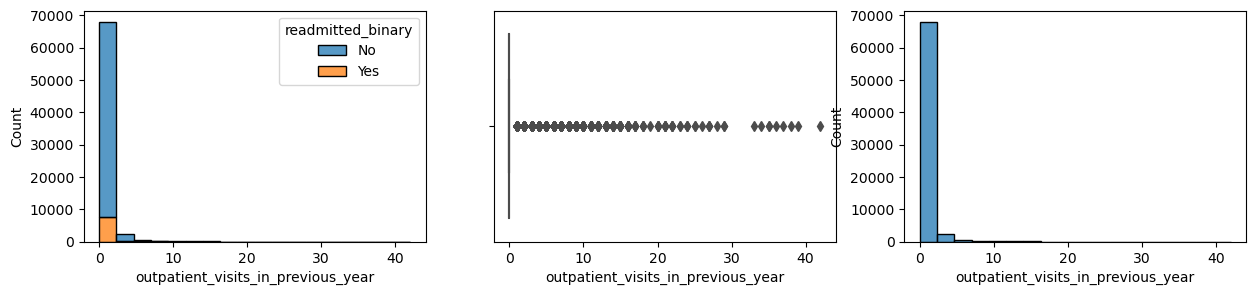

In [14]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = train, x = 'outpatient_visits_in_previous_year', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = train, x = 'outpatient_visits_in_previous_year', ax=ax[2])
sns.boxplot(data = train, x = 'outpatient_visits_in_previous_year', color = 'b', ax=ax[1])
fig.show()

<Axes: xlabel='outpatient_visits_in_previous_year', ylabel='Count'>

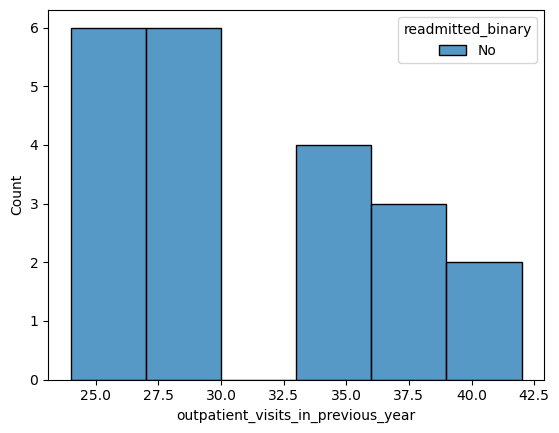

In [15]:
sns.histplot(data = df[df['outpatient_visits_in_previous_year']>=24], x = 'outpatient_visits_in_previous_year', hue = 'readmitted_binary', multiple= 'stack')

In [16]:
len(df[df['outpatient_visits_in_previous_year'] > 0])/len(df)

0.163526868437307

#### emergency_visits_in_previous_year

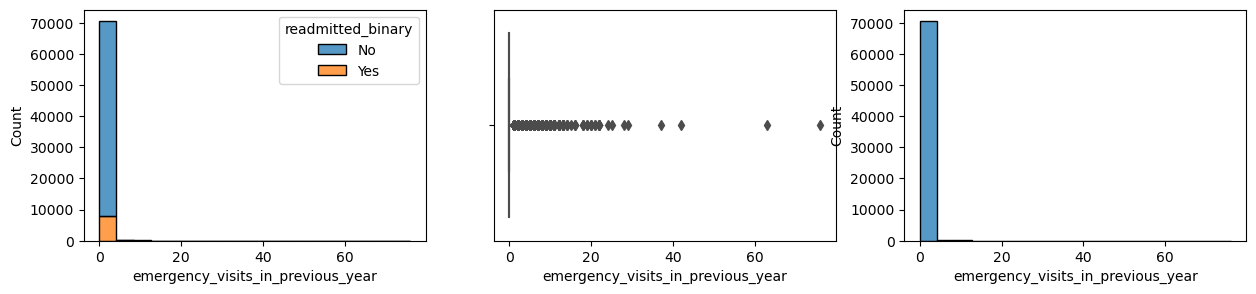

In [17]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'emergency_visits_in_previous_year', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'emergency_visits_in_previous_year', ax=ax[2])
sns.boxplot(data = df, x = 'emergency_visits_in_previous_year', color = 'b', ax=ax[1])
fig.show()

<Axes: xlabel='emergency_visits_in_previous_year', ylabel='Count'>

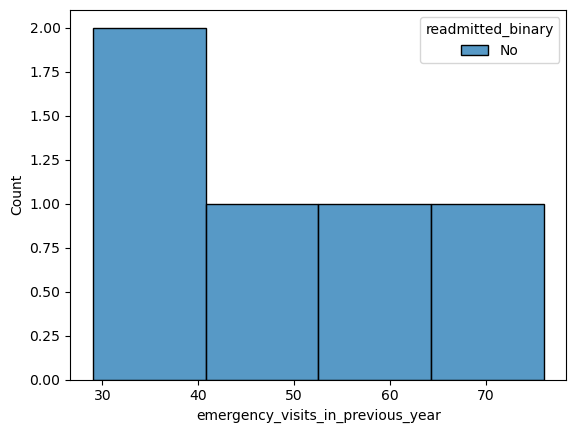

In [18]:
sns.histplot(data = df[df['emergency_visits_in_previous_year']>=29], x = 'emergency_visits_in_previous_year', hue = 'readmitted_binary', multiple= 'stack')

In [19]:
len(df[df['emergency_visits_in_previous_year'] > 0])/len(df)

0.11221854118704026

#### inpatient_visits_in_previous_year

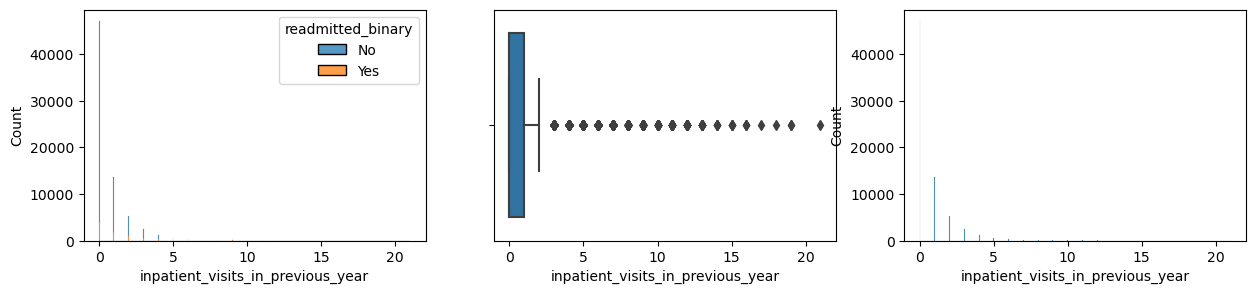

In [20]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'inpatient_visits_in_previous_year', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'inpatient_visits_in_previous_year', ax=ax[2])
sns.boxplot(data = df, x = 'inpatient_visits_in_previous_year', ax=ax[1])
fig.show()

<Axes: xlabel='inpatient_visits_in_previous_year', ylabel='Count'>

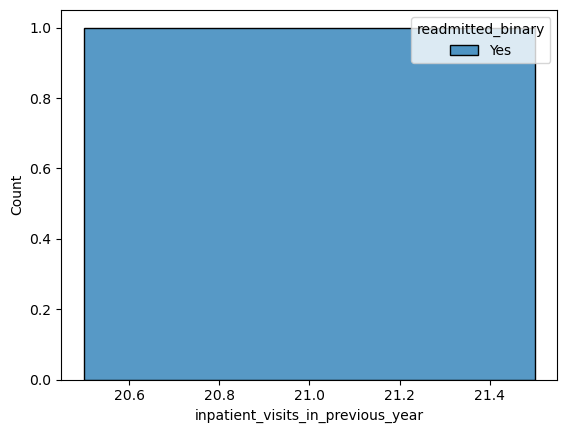

In [21]:
sns.histplot(data = df[df['inpatient_visits_in_previous_year']>=21], x = 'inpatient_visits_in_previous_year', hue = 'readmitted_binary', multiple= 'stack')

In [22]:
len(df[df['inpatient_visits_in_previous_year'] > 0])/len(df)

0.3369784940198776

#### average_pulse_bpm

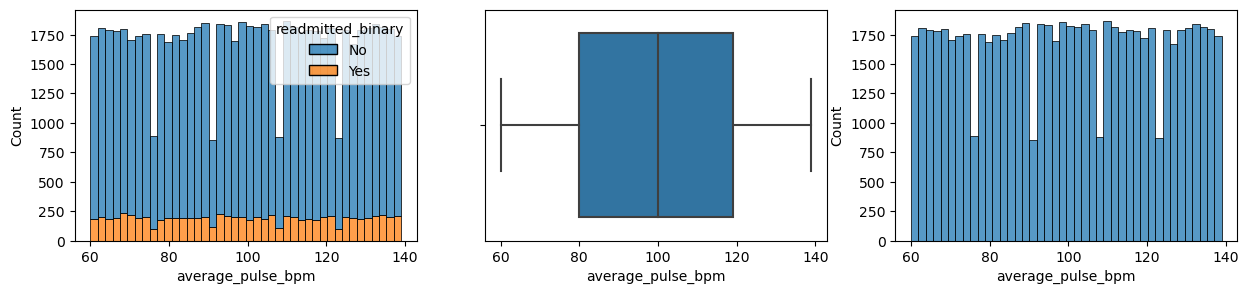

In [23]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'average_pulse_bpm', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'average_pulse_bpm', ax=ax[2])
sns.boxplot(data = df, x = 'average_pulse_bpm', ax=ax[1])
fig.show()

#### length_of_stay_in_hospital               

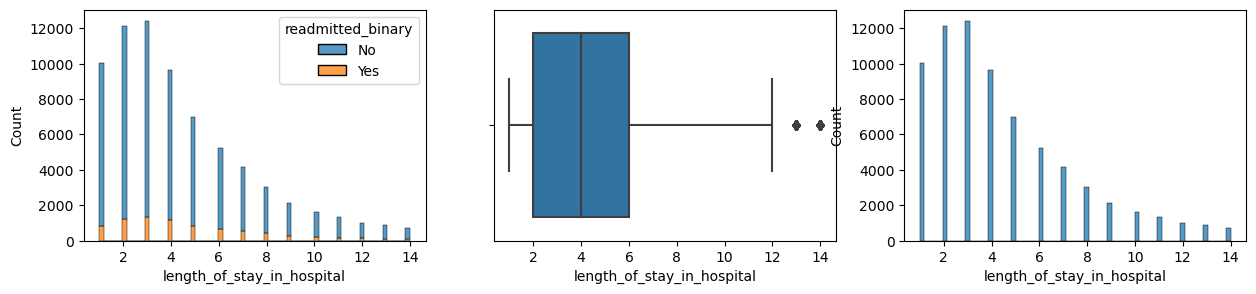

In [24]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'length_of_stay_in_hospital', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'length_of_stay_in_hospital', ax=ax[2])
sns.boxplot(data = df, x = 'length_of_stay_in_hospital', ax=ax[1])
fig.show()

#### number_lab_tests

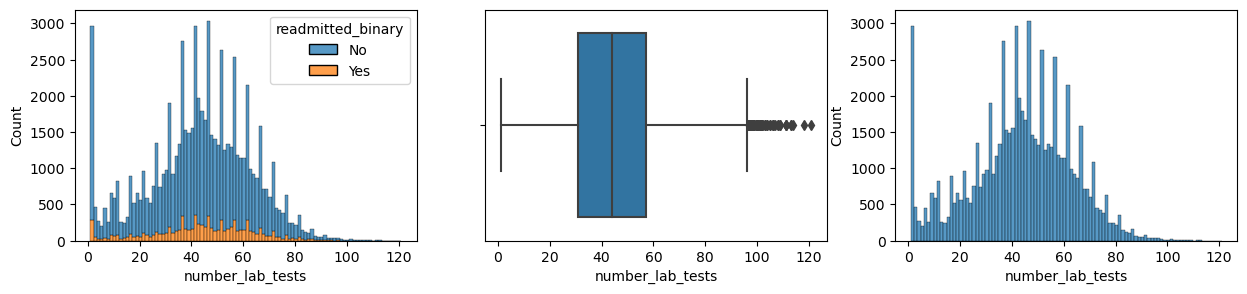

In [25]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'number_lab_tests', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'number_lab_tests', ax=ax[2])
sns.boxplot(data = df, x = 'number_lab_tests', ax=ax[1])
fig.show()

#### non_lab_procedures

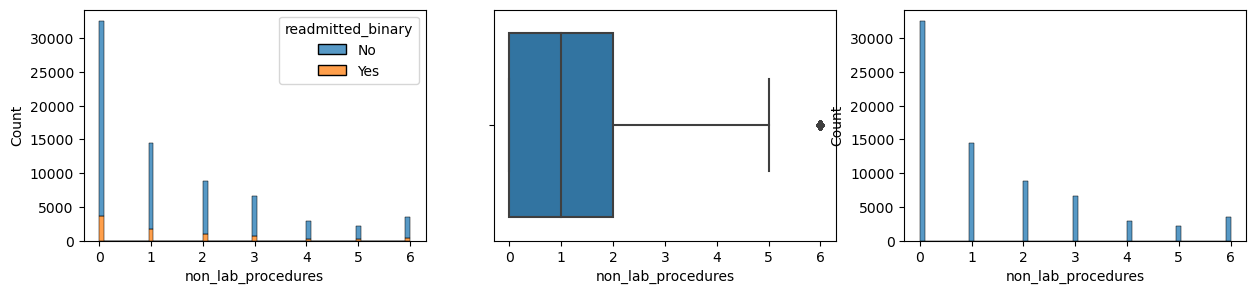

In [26]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'non_lab_procedures', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'non_lab_procedures', ax=ax[2])
sns.boxplot(data = df, x = 'non_lab_procedures',  ax=ax[1])
fig.show()

#### number_of_medications

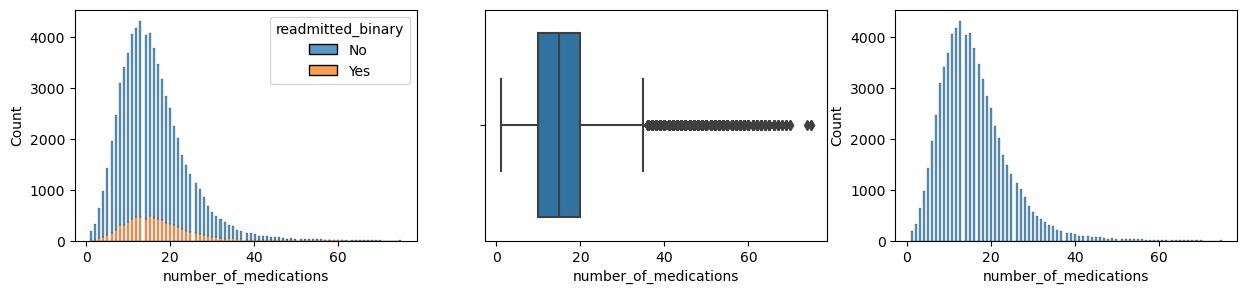

In [27]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'number_of_medications', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'number_of_medications', ax=ax[2])
sns.boxplot(data = df, x = 'number_of_medications', ax=ax[1])
fig.show()

<Axes: xlabel='number_of_medications', ylabel='Count'>

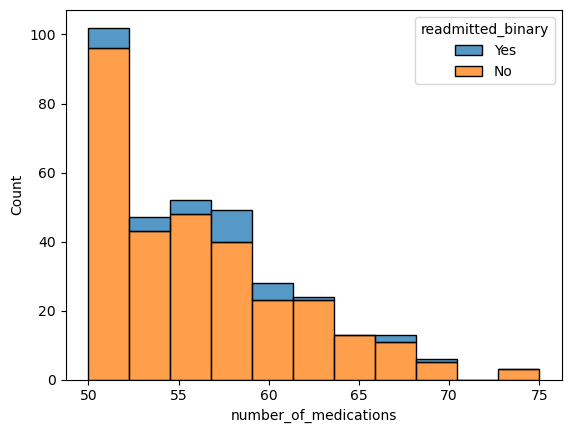

In [28]:
sns.histplot(data = df[df['number_of_medications']>=50], x = 'number_of_medications', hue = 'readmitted_binary', multiple= 'stack')

In [29]:
len(df[df['number_of_medications'] > 20])/len(df)

0.23322477399067887

#### number_diagnoses

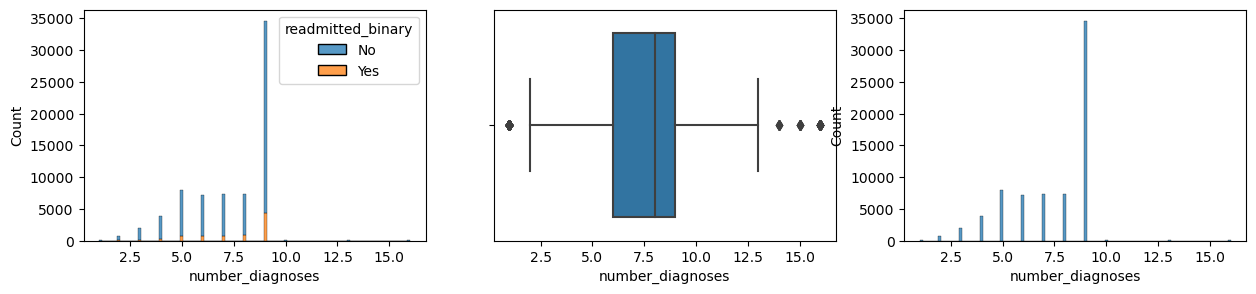

In [30]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'number_diagnoses', hue = 'readmitted_binary', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'number_diagnoses', ax=ax[2])
sns.boxplot(data = df, x = 'number_diagnoses', ax=ax[1])
fig.show()

## Categorical Features <a class="anchor" id="cat"></a>

#### race

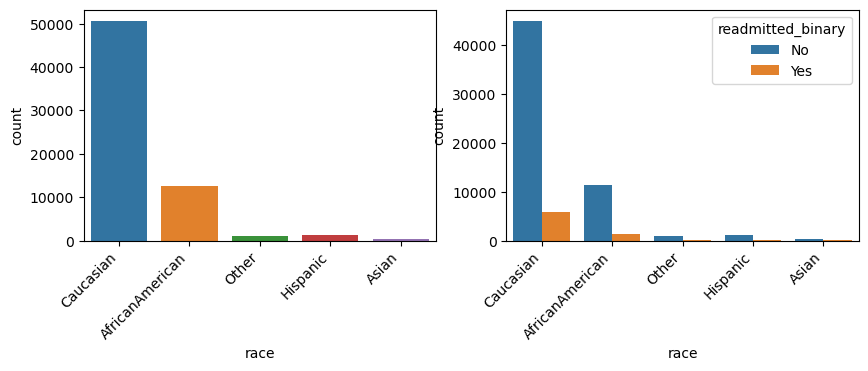

In [31]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'race', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'race', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### gender

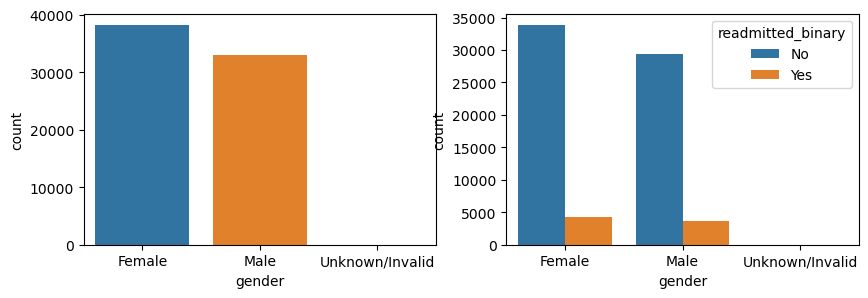

In [32]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'gender', ax=ax[0])
sns.countplot(data = df, x = 'gender', hue = 'readmitted_binary', ax=ax[1])
fig.show()

#### age

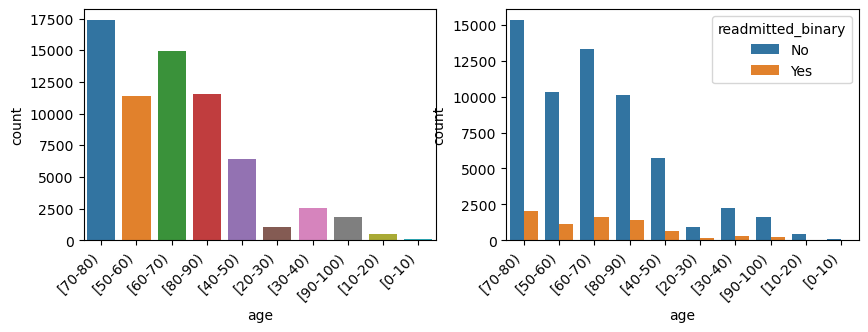

In [33]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'age', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'age', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### weight

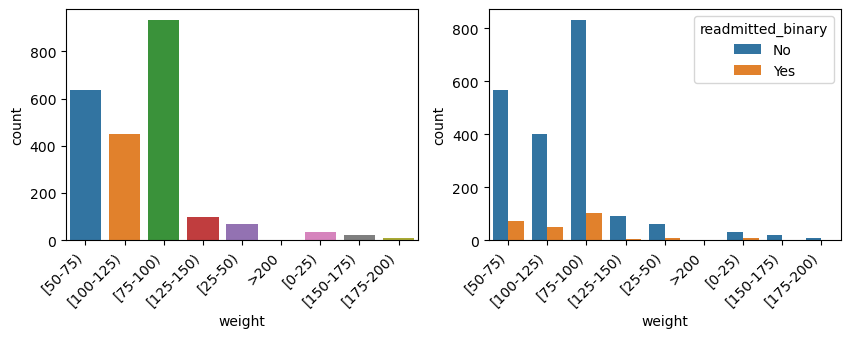

In [34]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'weight', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'weight', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### payer_code

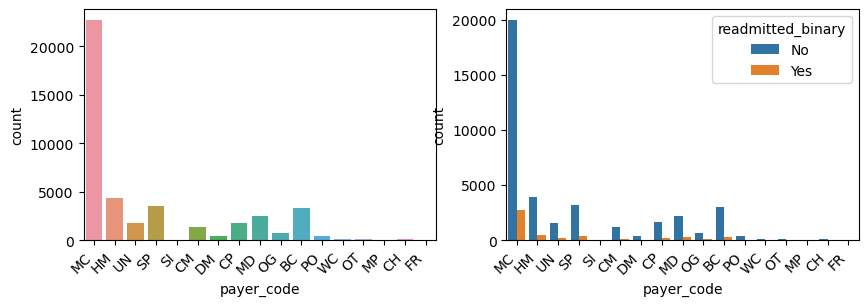

In [35]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'payer_code', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'payer_code', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### admission_type

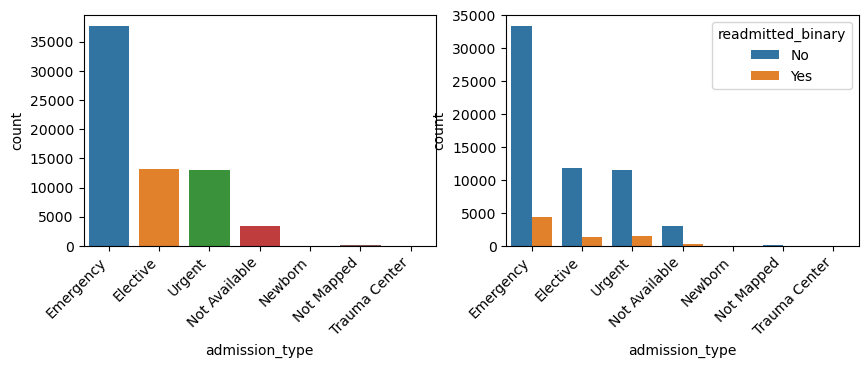

In [36]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'admission_type', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'admission_type', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### medical_specialty

In [37]:
df['medical_specialty'].value_counts(dropna = False)

medical_specialty
NaN                              34922
InternalMedicine                 10292
Emergency/Trauma                  5319
Family/GeneralPractice            5217
Cardiology                        3716
                                 ...  
Speech                               1
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Neurophysiology                      1
Name: count, Length: 69, dtype: int64

#### discharge_disposition

In [38]:
df['discharge_disposition'].value_counts(dropna = False)

discharge_disposition
Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
NaN                                                                                                           2590
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Expired                                                                                                       1135
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                

#### admission_source

In [39]:
df['admission_source'].value_counts(dropna = False)

admission_source
 Emergency Room                                               40319
 Physician Referral                                           20678
NaN                                                            4718
Transfer from a hospital                                       2230
 Transfer from another health care facility                    1562
Clinic Referral                                                 779
 Transfer from a Skilled Nursing Facility (SNF)                 595
HMO Referral                                                    129
 Not Mapped                                                     107
 Not Available                                                   88
 Court/Law Enforcement                                           11
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth              

#### primary_diagnosis

In [40]:
df['primary_diagnosis'].value_counts(dropna = False)

primary_diagnosis
428    4776
414    4596
786    2846
410    2513
486    2488
       ... 
412       1
375       1
147       1
422       1
299       1
Name: count, Length: 687, dtype: int64

#### secondary_diagnosis

In [41]:
df['secondary_diagnosis'].value_counts(dropna = False)

secondary_diagnosis
276     4694
428     4685
250     4257
427     3537
401     2624
        ... 
658        1
610        1
908        1
46         1
E968       1
Name: count, Length: 699, dtype: int64

#### additional_diagnosis

In [42]:
df['additional_diagnosis'].value_counts(dropna = False)

additional_diagnosis
250      8070
401      5784
276      3599
428      3240
427      2767
         ... 
250.3       1
930         1
811         1
E883        1
669         1
Name: count, Length: 747, dtype: int64

#### glucose_test_result

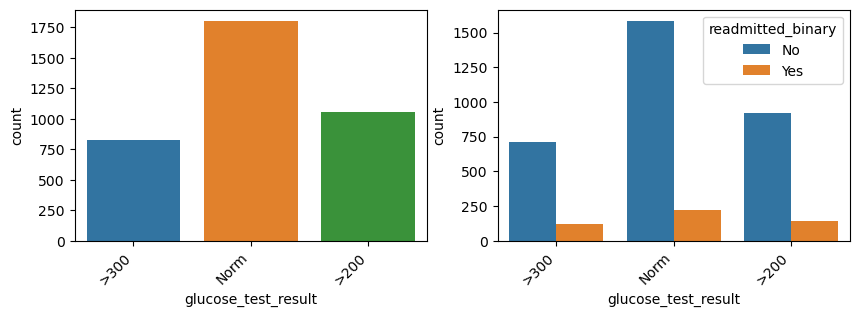

In [43]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'glucose_test_result', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'glucose_test_result', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### a1c_test_result

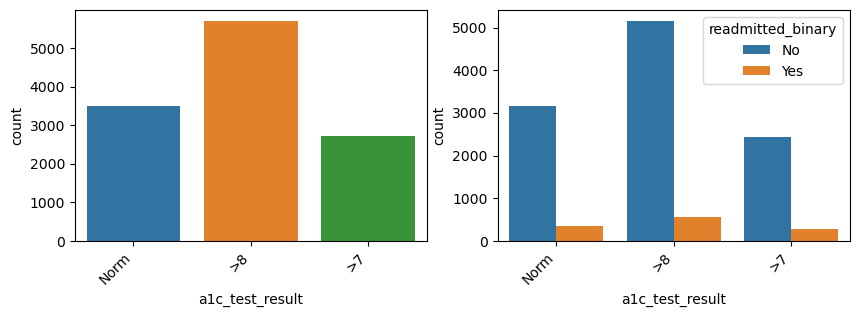

In [44]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'a1c_test_result', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'a1c_test_result', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### change_in_meds_during_hospitalization

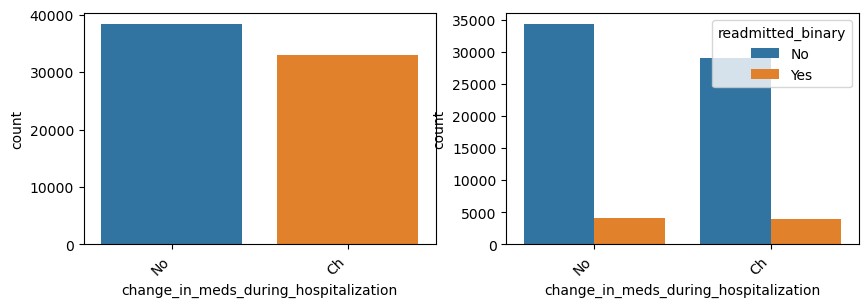

In [45]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'change_in_meds_during_hospitalization', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'change_in_meds_during_hospitalization', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### prescribed_diabetes_meds

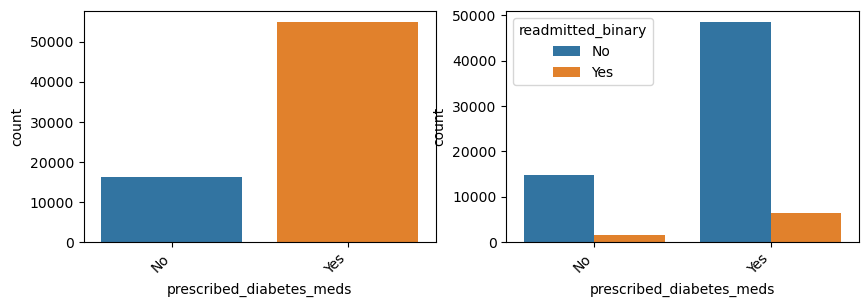

In [46]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'prescribed_diabetes_meds', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'prescribed_diabetes_meds', hue = 'readmitted_binary', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_binary')
fig.show()

#### medication

In [47]:
df['medication'].value_counts(dropna = False)

medication
['insulin']                                                       21715
[]                                                                16346
['metformin']                                                      3152
['metformin', 'insulin']                                           3041
['glipizide']                                                      2727
                                                                  ...  
['pioglitazone', 'acarbose', 'insulin', 'glyburide-metformin']        1
['glimepiride', 'rosiglitazone', 'acarbose']                          1
['glipizide', 'pioglitazone', 'acarbose', 'insulin']                  1
['metformin', 'glyburide', 'acarbose', 'insulin']                     1
['glimepiride', 'rosiglitazone', 'miglitol', 'insulin']               1
Name: count, Length: 303, dtype: int64

#### readmitted_binary

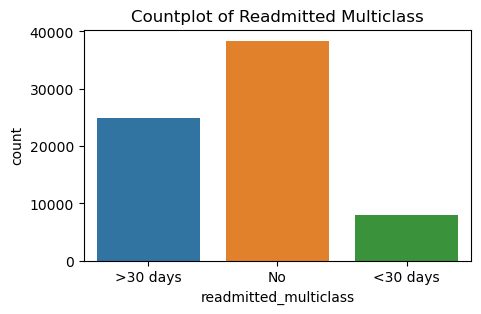

In [48]:
fig, ax =plt.subplots(1,1,figsize=(5, 3))
sns.countplot(data = df_train, x = 'readmitted_multiclass')
ax.set_title('Countplot of Readmitted Multiclass')
fig.show()
fig.savefig('countplot_mc.png')

#### readmitted_multiclass

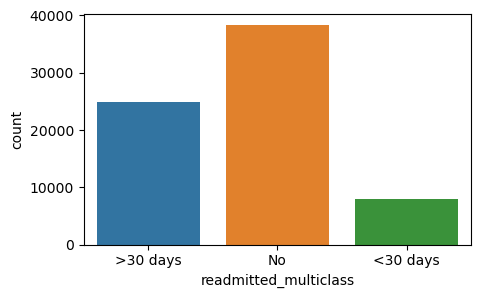

In [49]:
fig, ax =plt.subplots(1,1,figsize=(5, 3))
sns.countplot(data = df, x = 'readmitted_multiclass')
fig.show()

#### patient_id

In [50]:
train["patient_id"]

encounter_id
533253       70110
426224    29775006
634063    80729253
890610     2919042
654194    84871971
            ...   
660160    24531381
826429     4663818
332030    23397147
757560    52161750
459757    88410897
Name: patient_id, Length: 71236, dtype: int64

In [51]:
repeated_values = train['patient_id'].value_counts()
repeated_values = repeated_values[repeated_values > 1]
print(repeated_values)

patient_id
88785891     33
1660293      19
84428613     18
37096866     17
23199021     15
             ..
105797601     2
3446118       2
105263262     2
109114137     2
59142753      2
Name: count, Length: 10559, dtype: int64


In [52]:
train[(train['discharge_disposition']=="Hospice / home") & (train["readmitted_binary"]=="Yes")]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
369573,USA,93854601,Caucasian,Male,[80-90),[50-75),CM,0,0,0,...,784,E934,9,NaN,NaN,No,No,[],Yes,<30 days
317759,USA,8767800,Caucasian,Male,[70-80),NaN,NaN,0,0,0,...,428,426,7,NaN,NaN,No,Yes,['glyburide'],Yes,<30 days
969527,USA,12811878,Caucasian,Female,[80-90),NaN,NaN,12,2,6,...,518,585,9,NaN,NaN,No,Yes,['insulin'],Yes,<30 days
244648,USA,95075865,Caucasian,Male,[60-70),NaN,MD,3,4,0,...,599,198,9,NaN,NaN,Ch,Yes,['insulin'],Yes,<30 days
936958,USA,23717187,AfricanAmerican,Female,[90-100),NaN,MC,0,1,2,...,425,V66,6,NaN,NaN,No,Yes,['metformin'],Yes,<30 days
516866,USA,34301979,Caucasian,Male,[70-80),NaN,MC,0,1,1,...,707,263,9,NaN,NaN,No,No,[],Yes,<30 days
252583,USA,95060412,Caucasian,Female,[80-90),NaN,MC,0,0,0,...,789,332,9,NaN,NaN,No,Yes,['insulin'],Yes,<30 days
660381,USA,66776904,Caucasian,Female,[70-80),NaN,NaN,0,0,3,...,428,403,9,NaN,NaN,No,Yes,['glyburide'],Yes,<30 days
679728,USA,111138912,AfricanAmerican,Male,[60-70),NaN,NaN,0,0,1,...,157,199,8,NaN,NaN,Ch,Yes,"['pioglitazone', 'insulin']",Yes,<30 days


In [53]:
train[train["readmitted_binary"]=="Yes"]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
345921,USA,63536886,Caucasian,Male,[80-90),NaN,NaN,0,0,0,...,403,428,7,NaN,NaN,Ch,Yes,"['glipizide', 'insulin']",Yes,<30 days
873304,USA,23492133,AfricanAmerican,Female,[60-70),NaN,NaN,0,0,0,...,403,496,8,NaN,NaN,No,No,[],Yes,<30 days
102821,USA,30520872,Caucasian,Female,[60-70),NaN,MC,0,0,1,...,682,428,9,NaN,NaN,Ch,Yes,['insulin'],Yes,<30 days
844139,USA,24854895,Caucasian,Male,NaN,NaN,NaN,0,0,1,...,491,682,9,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
825255,USA,3509442,Caucasian,Male,[50-60),NaN,NaN,0,0,1,...,996,433,9,NaN,NaN,No,No,[],Yes,<30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259379,USA,29662614,Caucasian,Female,[60-70),NaN,MC,4,0,0,...,518,569,9,NaN,NaN,Ch,Yes,"['metformin', 'pioglitazone', 'insulin']",Yes,<30 days
631066,USA,24858882,Caucasian,Male,[70-80),NaN,MC,0,0,0,...,276,536,9,NaN,NaN,Ch,Yes,"['metformin', 'insulin']",Yes,<30 days
397846,USA,57184236,Caucasian,Female,[80-90),NaN,MC,0,0,2,...,434,250.02,9,NaN,NaN,No,Yes,['insulin'],Yes,<30 days


In [54]:
train[(train['glucose_test_result']==">300")& (train["readmitted_binary"]=="Yes")]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
844139,USA,24854895,Caucasian,Male,NaN,NaN,NaN,0,0,1,...,491,682,9,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
844722,USA,23619924,Caucasian,Female,[70-80),NaN,NaN,0,0,0,...,401,250,4,>300,NaN,Ch,Yes,"['metformin', 'pioglitazone', 'insulin']",Yes,<30 days
335808,USA,23661198,Caucasian,Male,[50-60),NaN,MC,1,0,0,...,428,424,9,>300,NaN,Ch,Yes,"['metformin', 'glipizide', 'rosiglitazone', 'i...",Yes,<30 days
283073,USA,25841151,AfricanAmerican,Male,[40-50),NaN,NaN,1,0,0,...,250.03,401,6,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
333098,USA,24209856,Caucasian,Female,NaN,NaN,MD,0,1,3,...,70,303,8,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578889,USA,25869789,Caucasian,Male,NaN,NaN,NaN,1,2,0,...,491,276,7,>300,NaN,Ch,Yes,"['glipizide', 'insulin']",Yes,<30 days
864300,USA,23643405,Caucasian,Female,[20-30),NaN,HM,0,4,13,...,250.41,578,7,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
846465,USA,24269553,Caucasian,Male,NaN,NaN,NaN,1,3,1,...,250.01,278,9,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days


In [55]:
train[(train['glucose_test_result']=="Norm")& (train["readmitted_binary"]=="Yes")]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
891370,USA,23382351,Caucasian,Female,[80-90),NaN,MC,2,0,0,...,401,250,4,Norm,NaN,Ch,Yes,"['glyburide', 'insulin']",Yes,<30 days
754155,USA,54026280,Hispanic,Female,[60-70),NaN,NaN,0,0,0,...,562,535,6,Norm,NaN,No,No,[],Yes,<30 days
925506,USA,95930262,Caucasian,Female,[70-80),NaN,NaN,0,0,1,...,780,780,6,Norm,NaN,No,Yes,['glyburide'],Yes,<30 days
593152,USA,23512842,Caucasian,Female,[80-90),NaN,NaN,0,0,2,...,428,496,9,Norm,NaN,Ch,Yes,['insulin'],Yes,<30 days
732548,USA,99421578,Caucasian,Female,[90-100),NaN,HM,1,1,0,...,578,427,9,Norm,NaN,No,No,[],Yes,<30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802711,USA,4778442,AfricanAmerican,Female,[70-80),NaN,NaN,0,0,0,...,250,401,3,Norm,NaN,No,Yes,['insulin'],Yes,<30 days
289939,USA,23393988,Caucasian,Male,[70-80),NaN,NaN,3,0,1,...,511,496,8,Norm,NaN,No,Yes,['glipizide'],Yes,<30 days
819403,USA,23378175,Caucasian,Female,[50-60),NaN,NaN,0,0,0,...,276,465,8,Norm,NaN,No,Yes,['metformin'],Yes,<30 days


# Preprocessing steps <a class="anchor" id="preprocessing"></a>

## Incoherences <a class="anchor" id="incoherences"></a>

In [56]:
# Newborns with incorrect ages

age_to_exclude = ['[70-80)', '[50-60)', '[60-70)', '[80-90)', '[40-50)', '[20-30)', '[30-40)', '[90-100)', '[10-20)']

train = train.drop(train[(train["admission_type"] == "Newborn") & (train["age"].isin(age_to_exclude))].index)

In [57]:
# We will group the discharge_disposition later, so we decided to drop discharge_disposition with Expired

discharge_to_exclude = [
    'Expired',
    'Expired at home. Medicaid only, hospice.',
    'Expired in a medical facility. Medicaid only, hospice.'
]

train = train[~train['discharge_disposition'].isin(discharge_to_exclude)]

In [58]:
# Drop the gender with "Unknown/Invalid"

train = train[train['gender'] != "Unknown/Invalid"]

In [59]:
# Drop the Sick Baby and Extramural Birth with incorrect age

train = train[train['admission_source']!=" Sick Baby"]
train = train[train['admission_source']!=' Extramural Birth']

In [60]:
train.shape[0]/71236

0.9838284013700938

## Outliers <a class="anchor" id="outliers"></a>

In [61]:
numerical_features = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']
categorical_features = train.columns.drop(numerical_features).to_list()

In [62]:
train[numerical_features].kurt() # a distribuição normal pela kurtose é evbidenciada quando a mesma é 3
# pelo que só vamos tomar atenção a valores superiores a 3 (n vemos o "number_od_medications" pq é mt proximo de 3 e é quase uma distribuição normal)

outpatient_visits_in_previous_year     154.037224
emergency_visits_in_previous_year     1210.468503
inpatient_visits_in_previous_year       20.386848
average_pulse_bpm                       -1.189798
length_of_stay_in_hospital               0.862472
number_lab_tests                        -0.264841
non_lab_procedures                       0.887171
number_of_medications                    3.512509
number_diagnoses                        -0.097114
dtype: float64

In [63]:
train[(train["outpatient_visits_in_previous_year"]>22) & (train["readmitted_binary"]=="Yes")] # threshold = maior q 23

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
472104,USA,1978605,Caucasian,Female,[50-60),NaN,NaN,23,0,2,...,997,250.02,9,NaN,NaN,Ch,Yes,['insulin'],Yes,<30 days


In [64]:
train[(train["inpatient_visits_in_previous_year"]>20) & (train["readmitted_binary"]=="Yes")] # threshold = maior q 21

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
357915,USA,4790016,Caucasian,Female,[20-30),[50-75),MC,0,1,21,...,577,309,7,NaN,NaN,No,Yes,['insulin'],Yes,<30 days


In [65]:
train[(train["emergency_visits_in_previous_year"]>27) & (train["readmitted_binary"]=="Yes")] # threshold = maior q 28

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
641150,USA,5539599,Caucasian,Male,[50-60),NaN,NaN,2,28,5,...,682,844,6,NaN,>7,No,No,[],Yes,<30 days


In [66]:
train[(train["number_of_medications"]>69) & (train["readmitted_binary"]=="Yes")] # threshold = maior q 70

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
128311,USA,25162767,AfricanAmerican,Female,[50-60),NaN,SP,0,0,0,...,584,427,9,NaN,NaN,Ch,Yes,['insulin'],Yes,<30 days


In [67]:
# Alteração ao dataset ( remover outliers )

# Basicamente aqui aplicamos o método windsorizing manualmente, dps das análises gráficas ( explicar o que faz este método no report )

# aplicamos manuamente ºpq neste projeto a dificuldade é descobrir quem volta e aplicando os thresholds escolhidos conseguimos treinar melhor o modelo para esse aspeto

train.loc[train["outpatient_visits_in_previous_year"]>23, "outpatient_visits_in_previous_year"] = 24

train.loc[train["inpatient_visits_in_previous_year"]>21, "inpatient_visits_in_previous_year"] = 22

train.loc[train["emergency_visits_in_previous_year"]>28, "emergency_visits_in_previous_year"] = 29

## Missing Values <a class="anchor" id="miss"></a>

In [68]:
train.isna().sum()

country                                      0
patient_id                                   0
race                                      4989
gender                                       0
age                                       3506
weight                                   67869
payer_code                               27750
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3659
medical_specialty                        34339
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4630
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           16
secondary_diagnosis                        262
additional_di

In [69]:
# We will keep "race" and fill the missing values with mode

train["race"].value_counts()

race
Caucasian          49862
AfricanAmerican    12483
Hispanic            1351
Other                983
Asian                416
Name: count, dtype: int64

In [70]:
# We will keep "age" and fill the missing values with mode

train["age"].value_counts()

age
[70-80)     17016
[60-70)     14704
[50-60)     11321
[80-90)     11183
[40-50)      6382
[30-40)      2529
[90-100)     1799
[20-30)      1067
[10-20)       473
[0-10)        104
Name: count, dtype: int64

In [71]:
# We will drop "weight" but we are doing a binary feature as missing values or not

In [72]:
# https://www.mass.gov/doc/hsn-payer-code-list20130118pdf/download
# Payer_Code -> Code of the health insurance provider (if there is one)
# So this Nan values we need to input with SP = Self Payed

train["payer_code"].value_counts()

payer_code
MC    22202
HM     4279
SP     3503
BC     3270
MD     2453
CP     1732
UN     1713
CM     1326
OG      721
PO      400
DM      375
CH      101
WC       99
OT       60
MP       54
SI       45
FR        1
Name: count, dtype: int64

In [73]:
# We will keep "admission_type" and fill the missing values with mode

train["admission_type"].value_counts()

admission_type
Emergency        36973
Elective         13115
Urgent           12848
Not Available     3262
Not Mapped         214
Trauma Center       12
Newborn              1
Name: count, dtype: int64

In [74]:
# We will keep "medical_specialty" and fill the missing values with "Other"

train["medical_specialty"].value_counts()

medical_specialty
InternalMedicine                 10090
Emergency/Trauma                  5237
Family/GeneralPractice            5122
Cardiology                        3675
Surgery-General                   2120
                                 ...  
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Pediatrics-EmergencyMedicine         1
Neurophysiology                      1
Name: count, Length: 68, dtype: int64

In [75]:
# We will keep "discharge_disposition" and fill the missing values with mode

train["discharge_disposition"].value_counts()

discharge_disposition
Discharged to home                                                                                           42249
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9003
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1392
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                                                                                  571
Left AMA                                                  

In [76]:
# We will keep "admission_source" and fill the missing values with mode

train["admission_source"].value_counts()

admission_source
 Emergency Room                                               39534
 Physician Referral                                           20505
Transfer from a hospital                                       2188
 Transfer from another health care facility                    1545
Clinic Referral                                                 767
 Transfer from a Skilled Nursing Facility (SNF)                 566
HMO Referral                                                    127
 Not Mapped                                                     106
 Not Available                                                   88
 Court/Law Enforcement                                           10
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
Normal Delivery                                                   1
Name: count, dtype: int64

In [77]:
# We will keep "primary_diagnosis" and fill the missing values with mode

train["primary_diagnosis"].value_counts()

primary_diagnosis
428    4683
414    4573
786    2846
410    2418
486    2416
       ... 
147       1
422       1
219       1
875       1
299       1
Name: count, Length: 684, dtype: int64

In [78]:
# We will keep "secondary_diagnosis" and fill the missing values with "primary_diagnosis" mode to keep consistency

train["secondary_diagnosis"].value_counts()

secondary_diagnosis
276     4622
428     4596
250     4247
427     3458
401     2617
        ... 
916        1
833        1
E868       1
944        1
E968       1
Name: count, Length: 697, dtype: int64

In [79]:
# We will keep "additional_diagnosis" and fill the missing values with "primary_diagnosis" mode to keep consistency

train["additional_diagnosis"].value_counts()

additional_diagnosis
250     8027
401     5747
276     3495
428     3160
427     2684
        ... 
E892       1
602        1
164        1
597        1
669        1
Name: count, Length: 744, dtype: int64

In [80]:
# We will drop 'glucose_test_result' and 'a1c_test_result' but we are doing a binary feature as missing values or not

In [81]:
# race

train["race"] = train["race"].replace(np.nan, train["race"].mode()[0])
test["race"] = test["race"].replace(np.nan, test["race"].mode()[0])

# age

train["age"] = train["age"].replace(np.nan, train["age"].mode()[0])
test["age"] = test["age"].replace(np.nan, test["age"].mode()[0])

# payer_code

train["payer_code"] = train["payer_code"].replace(np.nan, "SP")
test["payer_code"] = test["payer_code"].replace(np.nan, "SP")

# admission_type

train["admission_type"] = train["admission_type"].replace(np.nan, "Not Available")
test["admission_type"] = test["admission_type"].replace(np.nan, "Not Available")

# medical_specialty

train["medical_specialty"] = train["medical_specialty"].replace(np.nan, "Other")
test["medical_specialty"] = test["medical_specialty"].replace(np.nan, "Other")

# discharge_disposition

train["discharge_disposition"] = train["discharge_disposition"].replace(np.nan, "Not Available")
test["discharge_disposition"] = test["discharge_disposition"].replace(np.nan, "Not Available")

# admission_source

train["admission_source"] = train["admission_source"].replace(np.nan, "Not Available")
test["admission_source"] = test["admission_source"].replace(np.nan, "Not Available")

# primary_diagnosis

train["primary_diagnosis"] = train["primary_diagnosis"].replace(np.nan, train["primary_diagnosis"].mode()[0])
test["primary_diagnosis"] = test["primary_diagnosis"].replace(np.nan, test["primary_diagnosis"].mode()[0])

# secondary_diagnosis

train["secondary_diagnosis"] = train["secondary_diagnosis"].replace(np.nan, train["secondary_diagnosis"].mode()[0])
test["secondary_diagnosis"] = test["secondary_diagnosis"].replace(np.nan, test["secondary_diagnosis"].mode()[0])

# additional_diagnosis

train["additional_diagnosis"] = train["additional_diagnosis"].replace(np.nan, train["additional_diagnosis"].mode()[0])
test["additional_diagnosis"] = test["additional_diagnosis"].replace(np.nan, test["additional_diagnosis"].mode()[0])

In [82]:
train.loc[353655]

country                                                  USA
patient_id                                          28219392
race                                               Caucasian
gender                                                Female
age                                                  [60-70)
weight                                             [100-125)
payer_code                                                MC
outpatient_visits_in_previous_year                         1
emergency_visits_in_previous_year                          0
inpatient_visits_in_previous_year                          0
admission_type                                        Urgent
medical_specialty                           InternalMedicine
average_pulse_bpm                                        121
discharge_disposition                     Discharged to home
admission_source                          Physician Referral
length_of_stay_in_hospital                                 3
number_lab_tests        

In [83]:
test["primary_diagnosis"].value_counts()

primary_diagnosis
428    2091
414    1985
786    1170
410    1101
486    1020
       ... 
804       1
990       1
833       1
653       1
867       1
Name: count, Length: 594, dtype: int64

In [84]:
train.isna().sum()

country                                      0
patient_id                                   0
race                                         0
gender                                       0
age                                          0
weight                                   67869
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                               0
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                        0
admission_source                             0
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

In [85]:
test.isna().sum()

country                                      0
patient_id                                   0
race                                         0
gender                                       0
age                                          0
weight                                   29579
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                               0
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                        0
admission_source                             0
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

## Feature Engineering <a class="anchor" id="feature_eng"></a>

In [86]:
# Log transforamtion to get better distributions

In [87]:
train['log_outpatient_visits_in_previous_year'] = np.log1p(train['outpatient_visits_in_previous_year'])
test['log_outpatient_visits_in_previous_year'] = np.log1p(test['outpatient_visits_in_previous_year'])

In [88]:
train['log_emergency_visits_in_previous_year'] = np.log1p(train['emergency_visits_in_previous_year'])
test['log_emergency_visits_in_previous_year'] = np.log1p(test['emergency_visits_in_previous_year'])

In [89]:
train['log_inpatient_visits_in_previous_year'] = np.log1p(train['inpatient_visits_in_previous_year'])
test['log_inpatient_visits_in_previous_year'] = np.log1p(test['inpatient_visits_in_previous_year'])

In [90]:
# "visits_in_previous_year" -> sum of all patient visit in previous year

train["visits_in_previous_year"] = train["outpatient_visits_in_previous_year"] + train["emergency_visits_in_previous_year"] + train["inpatient_visits_in_previous_year"]
test["visits_in_previous_year"] = test["outpatient_visits_in_previous_year"] + test["emergency_visits_in_previous_year"] + test["inpatient_visits_in_previous_year"]

In [91]:
train.isna().sum()

country                                       0
patient_id                                    0
race                                          0
gender                                        0
age                                           0
weight                                    67869
payer_code                                    0
outpatient_visits_in_previous_year            0
emergency_visits_in_previous_year             0
inpatient_visits_in_previous_year             0
admission_type                                0
medical_specialty                             0
average_pulse_bpm                             0
discharge_disposition                         0
admission_source                              0
length_of_stay_in_hospital                    0
number_lab_tests                              0
non_lab_procedures                            0
number_of_medications                         0
primary_diagnosis                             0
secondary_diagnosis                     

In [92]:
# "'medication_'+mclass" -> all medications in binary features

train['medication'] = train['medication'].apply(lambda x: ast.literal_eval(x))

test['medication'] = test['medication'].apply(lambda x: ast.literal_eval(x))

med_list = []
for i in range(len(train)):
    med_list.append(train.medication.iloc[i])

med_classes = np.unique([num for elem in med_list for num in elem])

for mclass in med_classes:
    train['medication_'+mclass] = train['medication'].apply(lambda x: 1 if mclass in x else 0)

    test['medication_'+mclass] = test['medication'].apply(lambda x: 1 if mclass in x else 0)


In [93]:
# make a feature named weight filling missing values with mode

In [94]:
# 'weight_bin' -> binary feature 1 if the patient has weight record else 0

train['weight_bin'] = train['weight'].notna().astype(int)

test['weight_bin'] = test['weight'].notna().astype(int)

In [95]:
# "test_result" -> 1 if respects the conditions else 0

conditions_train = (
    (train['a1c_test_result'] == '>7') |
    (train['a1c_test_result'] == '>8') |
    (train['glucose_test_result'] == '>200') |
    (train['glucose_test_result'] == '>300')
)

train['test_result'] = conditions_train.astype(int)

conditions_test = (
    (test['a1c_test_result'] == '>7') |
    (test['a1c_test_result'] == '>8') |
    (test['glucose_test_result'] == '>200') |
    (test['glucose_test_result'] == '>300')
)

test['test_result'] = conditions_test.astype(int)

In [96]:
# "regular patient" -> 1 if patient_id is repeated in the data else 0

train['regular_patient'] = train.groupby('patient_id')['patient_id'].transform('count') > 1
train['regular_patient'] = train['regular_patient'].astype(int)

test['regular_patient'] = test.groupby('patient_id')['patient_id'].transform('count') > 1
test['regular_patient'] = test['regular_patient'].astype(int)

In [97]:
# "gender_bin" -> 1 if its Female else 0

train['gender_bin'] = (train['gender'] == 'Female').astype(int)

test['gender_bin'] = (test['gender'] == 'Female').astype(int)

In [98]:
# "change_in_meds_during_hospitalization_bin" -> 1 if it changes else 0

train['change_in_meds_during_hospitalization_bin'] = (train['change_in_meds_during_hospitalization'] == 'Ch').astype(int)

test['change_in_meds_during_hospitalization_bin'] = (test['change_in_meds_during_hospitalization'] == 'Ch').astype(int)

In [99]:
# "prescribed_diabetes_meds_bin" -> 1 if it has meds else 0

train['prescribed_diabetes_meds_bin'] = (train['prescribed_diabetes_meds'] == 'Yes').astype(int)

test['prescribed_diabetes_meds_bin'] = (test['prescribed_diabetes_meds'] == 'Yes').astype(int)

In [100]:
# "readmitted_binary" -> 1 if it Yes else 0

train['readmitted_binary'] = (train['readmitted_binary'] == 'Yes').astype(int)

In [101]:
# Drop irrelevant features

features_to_drop = ["country", "patient_id", "gender", "weight", "medication", "glucose_test_result", "a1c_test_result", "change_in_meds_during_hospitalization","prescribed_diabetes_meds","outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year"]

train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

## Encoding and Grouping <a class="anchor" id="enc"></a>

In [102]:
# Mapping race

race_mapping = {
    'Caucasian': 0,
    'AfricanAmerican': 1,
    'Hispanic': 2,
    'Other': 3,
    'Asian': 4
}

train['race'] = train['race'].map(race_mapping)

test['race'] = test['race'].map(race_mapping)

In [103]:
# Mapping "age"

age_mapping = {"[0-10)": 5,
               '[10-20)': 15,
               '[20-30)': 25,
               '[30-40)': 35,
               '[40-50)': 45,
               '[50-60)': 55,
               '[60-70)': 65,
               '[70-80)': 75,
               '[80-90)': 85,
               '[90-100)': 95}

train['age'] = train['age'].map(age_mapping)

test['age'] = test['age'].map(age_mapping)

In [104]:
train["payer_code"].value_counts()

payer_code
SP    31253
MC    22202
HM     4279
BC     3270
MD     2453
CP     1732
UN     1713
CM     1326
OG      721
PO      400
DM      375
CH      101
WC       99
OT       60
MP       54
SI       45
FR        1
Name: count, dtype: int64

In [105]:
# Mapping payer_code
# https://www.mass.gov/doc/hsn-payer-code-list20130118pdf/download

payer_code_mapping = {"SP": 0,
              "MC": 1,
              "HM": 2,
              "BC": 3,
              "MD": 4,
              "CP": 5,
              "UN": 6,
              "CM": 7,
              "OG": 8,
              "PO": 8,
              "DM": 8,
              "CH": 8,
              "WC": 8,
              "OT": 8,
              "MP": 8,
              "SI": 8,
              "FR": 8}

train['payer_code'] = train['payer_code'].map(payer_code_mapping)

test['payer_code'] = test['payer_code'].map(payer_code_mapping)

In [106]:
train["admission_type"].value_counts()

admission_type
Emergency        36973
Elective         13115
Urgent           12848
Not Available     6921
Not Mapped         214
Trauma Center       12
Newborn              1
Name: count, dtype: int64

In [107]:
# Mapping admission_type

admission_type_mapping = {
                          "Emergency": 0,
                          "Elective": 1,
                          "Urgent": 2,
                          "Not Available": 3,
                          "Not Mapped": 3,
                          "Trauma Center": 4,
                          "Newborn": 5,
                          }

train['admission_type'] = train['admission_type'].map(admission_type_mapping)

test['admission_type'] = test['admission_type'].map(admission_type_mapping)

In [108]:
# Mapping medical_specialty
# https://run.unl.pt/bitstream/10362/145706/1/TGI1636.pdf

# AllergyandImmunology -> Allergy and Immunology = 0
# Pathology -> Anatomic and Clinical Pathology = 1
# Anesthesiology, Anesthesiology-Pediatric -> Anesthesiology = 2
# Dermatology -> Dermatology = 3
# Radiologist, Radiology -> Diagnostic Radiology = 4
# Emergency, Trauma -> Emergency Medicine = 5
# Family, GeneralPractice -> Family, GeneralPractice = 6
# Surgery-PlasticwithinHeadandNeck, Surgeon, Surgery-Cardiovascular, Surgery-Cardiovascular/Thoracic, SurgeryColon&Rectal, Surgery-General, Surgery-Maxillofacial, Surgery-Neuro, SurgeryPediatric, Surgery-Plastic, Surgery-Thoracic, Surgery-Vascular, SurgicalSpecialty -> General Surgery = 7
# Cardiology, DCPTEAM, Endocrinology, Endocrinology-Metabolism, Gastroenterology, Hematology, Hematology/Oncology, Hospitalist, InfectiousDiseases, InternalMedicine, Nephrology, Neurophysiology, Oncology, Proctology, Pulmonology, Rheumatology, SportsMedicine, Urology -> Internal medicine = 8
# Neurology -> Neurology = 9
# Gynecology, Obsterics&Gynecology-GynecologicOnco, Obstetrics,ObstetricsandGynecology -> Obstetrics and Gynecology = 10
# Ophthalmology -> Ophthalmology = 11
# Orthopedics, Orthopedics-Reconstructive -> Orthopaedic Surgery = 12
# Osteopath -> Osteopathic Neuromusculoskeletal Medicine = 13
# Dentistry, Podiatry, Psychology, Resident, Speech -> Other Healthcare Practitioners = 14
# Otolaryngology -> Otolaryngology-Head and Neck Surgery = 15
# Cardiology-Pediatric, Pediatrics, Pediatrics-AllergyandImmunology, PediatricsCriticalCare, Pediatrics-EmergencyMedicine, Pediatrics-Endocrinology, PediatricsHematology-Oncology, Pediatrics-InfectiousDiseases, Pediatrics-Neurology, PediatricsPulmonology, Perinatology, Psychiatry-Child/Adolescent -> Pediatrics = 16
# PhysicalMedicineandRehabilitation, PhysicianNotFound -> Physical Medicine and Rehabilitation = 17
# Psychiatry, Psychiatry-Addictive -> Psychiatry= 18
# OutreachServices -> Other = 19
medical_specialty_mapping = {
                                "AllergyandImmunology":0,
                                "Pathology":1,
                                "Anesthesiology":2,
                                "Anesthesiology-Pediatric":2,
                                "Dermatology ":3,
                                'Dermatology':3,
                                "Radiologist":4,
                                "Radiology":4,
                                "Emergency/Trauma":5,
                                "Family/GeneralPractice":6,
                                "Surgeon":7,
                                "Surgery-Cardiovascular":7,
                                "Surgery-Cardiovascular/Thoracic":7,
                                "Surgery-Colon&Rectal":7,
                                "Surgery-General":7,
                                "Surgery-Maxillofacial":7,
                                "Surgery-Neuro":7,
                                "Surgery-Pediatric":7,
                                "Surgery-Plastic":7,
                                "Surgery-Thoracic":7,
                                "Surgery-Vascular":7,
                                "SurgicalSpecialty":7,
                                "Surgery-PlasticwithinHeadandNeck":7,
                                "Cardiology":8,
                                "DCPTEAM":8,
                                "Endocrinology":8,
                                "Endocrinology-Metabolism":8,
                                "Gastroenterology":8,
                                "Hematology":8,
                                "Hematology/Oncology":8,
                                "Hospitalist":8,
                                "InfectiousDiseases":8,
                                "InternalMedicine":8,
                                "Nephrology":8,
                                "Neurophysiology":8,
                                "Oncology":8,
                                "Proctology":8,
                                "Pulmonology":8,
                                "Rheumatology":8,
                                "SportsMedicine":8,
                                "Urology":8,
                                "Neurology":9,
                                "Gynecology":10,
                                "Obsterics&Gynecology-GynecologicOnco":10,
                                "Obstetrics":10,
                                "ObstetricsandGynecology":10,
                                "Ophthalmology":11,
                                "Orthopedics":12,
                                "Orthopedics-Reconstructive":12,
                                "Osteopath":13,
                                "Dentistry":14,
                                "Podiatry":14,
                                "Psychology":14,
                                "Resident":14,
                                "Speech":14,
                                "Otolaryngology":15,
                                "Cardiology-Pediatric":16,
                                "Pediatrics":16,
                                "Pediatrics-AllergyandImmunology":16,
                                "Pediatrics-CriticalCare":16,
                                "Pediatrics-EmergencyMedicine":16,
                                "Pediatrics-Endocrinology":16,
                                "Pediatrics-Hematology-Oncology":16,
                                "Pediatrics-InfectiousDiseases":16,
                                "Pediatrics-Neurology":16,
                                "Pediatrics-Pulmonology":16,
                                "Perinatology":16,
                                "Psychiatry-Child/Adolescent":16,
                                "PhysicalMedicineandRehabilitation":17,
                                "PhysicianNotFound":17,
                                "Psychiatry":18,
                                "Psychiatry-Addictive":18,
                                "Other":19,
                                "OutreachServices":19

                          }

train['medical_specialty'] = train['medical_specialty'].map(medical_specialty_mapping)

test['medical_specialty'] = test['medical_specialty'].map(medical_specialty_mapping) # notebook is buging here!

In [109]:
train["discharge_disposition"].value_counts()

discharge_disposition
Discharged to home                                                                                           42249
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9003
Not Available                                                                                                 2590
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1392
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                             

In [110]:
# Mapping discharge_disposition

# Discharged to home = 0

# Transferred to another medical facility = 1

# Left AMA(Against Medical Advice.) = 2

# Still patient/referred to this institution= 3

# Not Available = 4

# Hospice = 5

# Expired = 6

discharge_disposition_mapping = {
                                "Discharged to home":0,
                                "Discharged/transferred to home with home health service":0,
                                "Discharged/transferred to home under care of Home IV provider":0,
                                "Discharged/transferred to a federal health care facility.":1,
                                "Discharged/transferred to SNF":1,
                                "Discharged/transferred to another short term hospital":1,
                                "Discharged/transferred to ICF":1,
                                "Discharged/transferred to another rehab fac including rehab units of a hospital .":1,
                                "Discharged/transferred to a long term care hospital.":1,
                                "Discharged/transferred to another type of inpatient care institution":1,
                                "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital":1,
                                "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.":1,
                                "Discharged/transferred/referred another institution for outpatient services":1,
                                'Neonate discharged to another hospital for neonatal aftercare':1,
                                "Left AMA":2,
                                "Admitted as an inpatient to this hospital":3,
                                "Still patient or expected to return for outpatient services":3,
                                "Discharged/transferred within this institution to Medicare approved swing bed":3,
                                "Discharged/transferred/referred to this institution for outpatient services":3,
                                'Not Mapped':4,
                                "Not Available":4,
                                'Hospice / home':5,
                                'Hospice / medical facility':5,
                                'Expired':6,
                                'Expired at home. Medicaid only, hospice.':6,
                                'Expired in a medical facility. Medicaid only, hospice.':6

                                }

train['discharge_disposition'] = train['discharge_disposition'].map(discharge_disposition_mapping)

test['discharge_disposition'] = test['discharge_disposition'].map(discharge_disposition_mapping)

In [111]:
# Mapping admission_source

# Emergency Room = 0
# Referral -> A written order from your primary care doctor for you to see a specialist or get certain medical services
# Referral = 1
# from hospital = 2
# Court/Law Enforcement = 3
# Not Mapped = 4
# from Critical acess = 5
# Sick baby = 6
# Normal delivery = 7
admission_source_mapping = {
                                ' Emergency Room':0,
                                'Clinic Referral':1,
                                'HMO Referral':1,
                                ' Physician Referral':1,
                                ' Transfer from another health care facility':2,
                                'Transfer from a hospital':2,
                                ' Transfer from a Skilled Nursing Facility (SNF)':2,
                                ' Transfer from hospital inpt/same fac reslt in a sep claim':2,
                                ' Court/Law Enforcement':3,
                                ' Not Available':4,
                                "Not Available":4,
                                ' Not Mapped':4,
                                ' Transfer from critial access hospital':5,
                                ' Transfer from Ambulatory Surgery Center':5,
                                " Sick Baby":6,
                                ' Extramural Birth':6,
                                "Normal Delivery":7,
                            }

train['admission_source'] = train['admission_source'].map(admission_source_mapping)

test['admission_source'] = test['admission_source'].map(admission_source_mapping)

In [112]:
# Mapping primary_diagnosis, secondary_diagnosis and additional_diagnosis

In [113]:
# Replace values starting with 'V' with -9999
train['primary_diagnosis'] = train['primary_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)
train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)
train['additional_diagnosis'] = train['additional_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)

# Replace values starting with 'V' with -9999
test['primary_diagnosis'] = test['primary_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)

In [114]:
# Replace values starting with 'E' with -10
train['primary_diagnosis'] = train['primary_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)
train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)
train['additional_diagnosis'] = train['additional_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)

# Replace values starting with 'E' with -10
test['primary_diagnosis'] = test['primary_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)

In [115]:
# Convert string numbers to numeric values
train['primary_diagnosis'] = pd.to_numeric(train['primary_diagnosis'], errors='coerce')
train['secondary_diagnosis'] = pd.to_numeric(train['secondary_diagnosis'], errors='coerce')
train['additional_diagnosis'] = pd.to_numeric(train['additional_diagnosis'], errors='coerce')

# Convert string numbers to numeric values
test['primary_diagnosis'] = pd.to_numeric(test['primary_diagnosis'], errors='coerce')
test['secondary_diagnosis'] = pd.to_numeric(test['secondary_diagnosis'], errors='coerce')
test['additional_diagnosis'] = pd.to_numeric(test['additional_diagnosis'], errors='coerce')

In [116]:
train['primary_diagnosis'] = train['primary_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)
train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)
train['additional_diagnosis'] = train['additional_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)

test['primary_diagnosis'] = test['primary_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)

In [117]:
# Mapping function
def map_diagnosis(x):
    if x in range(0, 140):
        return 0
    elif x in range(140, 240):
        return 1
    elif x in range(240, 280):
        return 2
    elif x in range(280, 290):
        return 3
    elif x in range(290, 320):
        return 4
    elif x in range(320, 390):
        return 5
    elif x in range(390, 460):
        return 6
    elif x in range(460, 520):
        return 7
    elif x in range(520, 580):
        return 8
    elif x in range(580, 630):
        return 9
    elif x in range(630, 677):
        return 10
    elif x in range(680, 710):
        return 11
    elif x in range(710, 740):
        return 12
    elif x in range(740, 760):
        return 13
    elif x in range(760, 780):
        return 14
    elif x in range(780, 800):
        return 15
    elif x in range(800, 1000):
        return 16
    elif x == -9999:
        return 17
    elif x == -10:
        return 18
    else:
        return x  # Return unchanged if not in any specified range

# Apply mapping function to both 'primary_diagnosis' and 'secondary_diagnosis'
train['primary_diagnosis'] = train['primary_diagnosis'].apply(map_diagnosis)
train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(map_diagnosis)
train['additional_diagnosis'] = train['additional_diagnosis'].apply(map_diagnosis)


test['primary_diagnosis'] = test['primary_diagnosis'].apply(map_diagnosis)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(map_diagnosis)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(map_diagnosis)

In [118]:
train.isna().sum(), test.isna().sum()

(race                                         0
 age                                          0
 payer_code                                   0
 admission_type                               0
 medical_specialty                            0
 average_pulse_bpm                            0
 discharge_disposition                        0
 admission_source                             0
 length_of_stay_in_hospital                   0
 number_lab_tests                             0
 non_lab_procedures                           0
 number_of_medications                        0
 primary_diagnosis                            0
 secondary_diagnosis                          0
 additional_diagnosis                         0
 number_diagnoses                             0
 readmitted_binary                            0
 readmitted_multiclass                        0
 log_outpatient_visits_in_previous_year       0
 log_emergency_visits_in_previous_year        0
 log_inpatient_visits_in_previous_year  

In [119]:
train.head().T

encounter_id,533253,426224,634063,890610,654194
race,0,1,0,1,0
age,75,55,65,65,75
payer_code,0,0,0,1,2
admission_type,0,0,3,0,1
medical_specialty,6,19,6,8,19
average_pulse_bpm,127,128,94,81,126
discharge_disposition,0,1,0,0,0
admission_source,0,1,4,2,1
length_of_stay_in_hospital,2,14,6,6,6
number_lab_tests,48,71,60,48,47


In [120]:
train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
race,70084.0,NaN,NaN,NaN,0.28249,0.629789,0.0,0.0,0.0,0.0,4.0
age,70084.0,NaN,NaN,NaN,66.334969,15.686335,5.0,55.0,65.0,75.0,95.0
payer_code,70084.0,NaN,NaN,NaN,1.3334,1.970473,0.0,0.0,1.0,1.0,8.0
admission_type,70084.0,NaN,NaN,NaN,0.859954,1.048939,0.0,0.0,0.0,2.0,5.0
medical_specialty,70084.0,NaN,NaN,NaN,13.232307,5.941622,0.0,8.0,17.0,19.0,19.0
average_pulse_bpm,70084.0,NaN,NaN,NaN,99.597768,23.037617,60.0,80.0,100.0,119.0,139.0
discharge_disposition,70084.0,NaN,NaN,NaN,0.445023,0.986194,0.0,0.0,0.0,1.0,5.0
admission_source,70084.0,NaN,NaN,NaN,0.70474,1.077503,0.0,0.0,0.0,1.0,7.0
length_of_stay_in_hospital,70084.0,NaN,NaN,NaN,4.38598,2.97868,1.0,2.0,4.0,6.0,14.0
number_lab_tests,70084.0,NaN,NaN,NaN,42.94137,19.587225,1.0,31.0,44.0,57.0,121.0


## Scaling <a class="anchor" id="scaling"></a>

In [121]:
x_train = train.drop(["readmitted_binary", "readmitted_multiclass"], axis = 1)

In [122]:
from sklearn.preprocessing import MinMaxScaler

In [123]:

scale_train = MinMaxScaler().fit(x_train)

train_scaled = scale_train.transform(x_train)
train_scaled = pd.DataFrame(train_scaled, columns = x_train.columns, index=x_train.index)

test_scaled = scale_train.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns = test.columns, index=test.index)

## Split and UnderSampler <a class="anchor" id="us"></a>

In [124]:
# Assuming 'X_train' contains the features and 'y_train' contains the target variable in the training set
X_train = train_scaled # Adjust columns accordingly
y_train = train['readmitted_binary']

# Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify= y_train, shuffle=True)


In [125]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {}\n".format(sum(y_train == 0)))

# Instantiate RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Fit and transform the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# After Undersampling
print('After Undersampling, the shape of X_train: {}'.format(X_resampled.shape))
print('After Undersampling, the shape of Y_train: {}\n'.format(y_resampled.shape))

print("After Undersampling, counts of label '1': {}".format(sum(y_resampled == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_resampled == 0)))

Before Undersampling, counts of label '1': 7950
Before Undersampling, counts of label '0': 62134

After Undersampling, the shape of X_train: (15900, 47)
After Undersampling, the shape of Y_train: (15900,)

After Undersampling, counts of label '1': 7950
After Undersampling, counts of label '0': 7950


In [126]:
X_resampled.isna().sum()

race                                         0
age                                          0
payer_code                                   0
admission_type                               0
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                        0
admission_source                             0
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_diagnosis                         0
number_diagnoses                             0
log_outpatient_visits_in_previous_year       0
log_emergency_visits_in_previous_year        0
log_inpatient_visits_in_previous_year        0
visits_in_previous_year                      0
medication_acarbose                          0
medication_ac

In [147]:
numerical_features = ['log_outpatient_visits_in_previous_year', 'log_emergency_visits_in_previous_year', 'log_inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses', "visits_in_previous_year"]
categorical_features = X_resampled.columns.drop(numerical_features).to_list()
len(numerical_features)

10

In [128]:
len(numerical_features) + len(categorical_features)

47

## PCA

In [129]:
from sklearn.decomposition import PCA

In [130]:
pca = PCA()
pca.fit(X_resampled)

PCA()

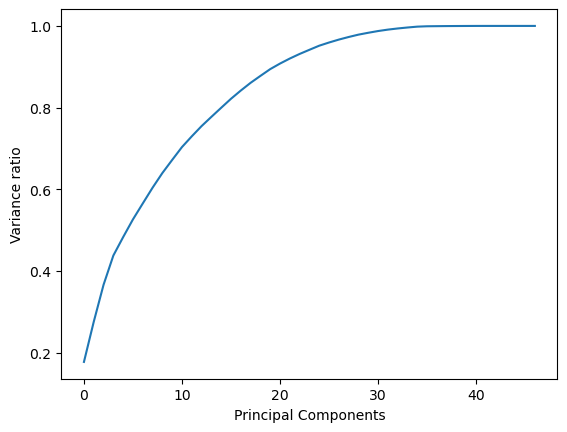

In [131]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Variance ratio')
plt.show()

In [132]:
n_components = 15
pca = PCA(n_components)
pca_scores_train = pca.fit_transform(X_resampled)

In [133]:
pca_scores_train

array([[-0.14953873,  0.90796075, -0.17042352, ...,  0.77294535,
         0.38728211,  0.27104057],
       [ 0.49246728,  0.41439085,  0.6962383 , ...,  0.2597532 ,
         0.12327934,  0.01906643],
       [-0.85999791, -0.01836589, -0.56612612, ...,  0.08882598,
         0.02739539, -0.38255881],
       ...,
       [-0.03008232, -0.80519286,  0.12910538, ...,  0.14253914,
        -0.06010262,  0.17659915],
       [-0.0504137 , -0.36929369, -0.776134  , ...,  0.0347445 ,
        -0.11709277,  0.18588526],
       [-0.75008046, -0.58966705,  0.22293949, ..., -0.27503675,
        -0.17579837, -0.04360022]])

In [134]:
columns_pca = []
for i in range(n_components):
    columns_pca.append('PCA'+str(i+1))
print(columns_pca)

['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15']


In [135]:
pca_coor = pd.DataFrame(data = pca_scores_train
             , columns = columns_pca, index = X_resampled.index)
pca_coor

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15
encounter_id,,,,,,,,,,,,,,,
253551,-0.149539,0.907961,-0.170424,0.244655,0.819579,0.263597,-0.138838,0.380161,-0.057154,-0.471489,-0.264907,1.038734,0.772945,0.387282,0.271041
914197,0.492467,0.414391,0.696238,0.486385,-0.157366,-0.317695,0.393047,-0.303523,0.069202,0.709555,0.232604,-0.161033,0.259753,0.123279,0.019066
719702,-0.859998,-0.018366,-0.566126,0.464705,-0.005674,-0.266240,0.506318,0.261478,-0.632301,0.308648,-0.321218,-0.109223,0.088826,0.027395,-0.382559
105710,-0.860972,0.396378,0.742746,0.469264,-0.124689,0.638208,0.186983,-0.130753,-0.279155,-0.070486,-0.072366,-0.242584,0.654518,-0.569517,0.251504
556161,1.122161,0.210226,0.587658,-0.144277,0.125085,0.104755,0.035730,0.446303,-0.266187,-0.232481,0.135580,0.018574,-0.200142,-0.226090,0.209144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259379,-0.777392,0.385455,0.765055,0.333188,-0.221262,-0.299497,-0.255294,-0.197937,-0.205595,0.469056,0.102544,0.380278,0.588983,-0.377449,0.266908
631066,-0.750370,0.820769,-0.152896,0.197115,-0.115678,-0.319478,0.258577,0.001081,-0.540129,0.206343,-0.254191,-0.370066,0.050643,-0.241179,0.049488
397846,-0.030082,-0.805193,0.129105,-0.448641,-0.200527,-0.190743,0.147285,-0.440064,0.196866,0.138347,-0.428700,-0.411708,0.142539,-0.060103,0.176599


In [136]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.17720189 0.09834723 0.09055188 0.07163605 0.04518126 0.04335685
 0.03893462 0.03860992 0.03593053 0.03208712 0.03151686 0.02625329
 0.02509379 0.0225884  0.02225748]


In [137]:
results_dict = {
        "Proportion": pca.explained_variance_ratio_,
        "Cumulative": np.cumsum(pca.explained_variance_ratio_),
    }
results_dict_df = pd.DataFrame(results_dict, index=pca_coor.columns.values )
results_dict_df


,Proportion,Cumulative
PCA1,0.177202,0.177202
PCA2,0.098347,0.275549
PCA3,0.090552,0.366101
PCA4,0.071636,0.437737
PCA5,0.045181,0.482918
PCA6,0.043357,0.526275
PCA7,0.038935,0.565210
PCA8,0.038610,0.603820
PCA9,0.035931,0.639750
PCA10,0.032087,0.671837


In [138]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [139]:
loadings

array([[-3.89813888e-04, -2.21118719e-03,  4.47221740e-03,
        -7.02878282e-03,  9.59010391e-04, -9.49918060e-04,
         5.39791664e-03,  3.14803815e-03, -9.17191790e-03,
        -4.31022379e-03,  4.11030808e-05, -9.06488731e-03,
         2.35960010e-03, -1.94869022e-03, -9.34667445e-03],
       [ 1.04539420e-02, -3.53251906e-03,  9.14899766e-03,
         1.01400052e-02, -1.94006279e-02,  1.21915594e-02,
        -1.29160456e-02,  1.70906257e-02,  3.29897681e-02,
         4.42311956e-03,  4.54574304e-03,  4.28442956e-03,
        -2.40227963e-02, -3.01181469e-02,  4.09969174e-02],
       [-2.63978991e-02, -4.14001235e-03, -3.96836199e-03,
         5.49604221e-04, -1.74263080e-02, -1.58675033e-02,
        -6.53960246e-03, -3.34569963e-02, -4.95316327e-02,
        -1.07211325e-02, -1.29707915e-02,  1.45799937e-02,
         7.11136555e-02,  8.69840136e-02, -1.44493298e-01],
       [-2.78203986e-03,  1.92207703e-02,  4.81407330e-03,
        -4.55515942e-03,  4.46043584e-02,  2.07527475

In [140]:
X_resampled.columns.values

array(['race', 'age', 'payer_code', 'admission_type', 'medical_specialty',
       'average_pulse_bpm', 'discharge_disposition', 'admission_source',
       'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'log_outpatient_visits_in_previous_year',
       'log_emergency_visits_in_previous_year',
       'log_inpatient_visits_in_previous_year', 'visits_in_previous_year',
       'medication_acarbose', 'medication_acetohexamide',
       'medication_chlorpropamide', 'medication_glimepiride',
       'medication_glimepiride-pioglitazone', 'medication_glipizide',
       'medication_glipizide-metformin', 'medication_glyburide',
       'medication_glyburide-metformin', 'medication_insulin',
       'medication_metformin', 'medication_metformin-pioglitazone',
       'medication_metformin-rosiglitazone', 'medication_miglitol',
       'medication_n

In [141]:
loadings_sat_df = pd.DataFrame(data = loadings
             , columns = columns_pca, index = X_resampled.columns.values)

In [142]:
loadings_sat_df

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15
race,-3.898139e-04,-2.211187e-03,4.472217e-03,-7.028783e-03,9.590104e-04,-9.499181e-04,5.397917e-03,3.148038e-03,-9.171918e-03,-4.310224e-03,4.110308e-05,-9.064887e-03,2.359600e-03,-1.948690e-03,-9.346674e-03
age,1.045394e-02,-3.532519e-03,9.148998e-03,1.014001e-02,-1.940063e-02,1.219156e-02,-1.291605e-02,1.709063e-02,3.298977e-02,4.423120e-03,4.545743e-03,4.284430e-03,-2.402280e-02,-3.011815e-02,4.099692e-02
payer_code,-2.639790e-02,-4.140012e-03,-3.968362e-03,5.496042e-04,-1.742631e-02,-1.586750e-02,-6.539602e-03,-3.345700e-02,-4.953163e-02,-1.072113e-02,-1.297079e-02,1.457999e-02,7.111366e-02,8.698401e-02,-1.444933e-01
admission_type,-2.782040e-03,1.922077e-02,4.814073e-03,-4.555159e-03,4.460436e-02,2.075275e-02,4.735558e-02,6.454944e-02,3.131867e-03,9.813718e-04,1.370119e-03,2.918515e-02,-2.230711e-02,1.590498e-02,2.072841e-02
medical_specialty,1.622636e-02,-1.213761e-02,-4.930354e-03,1.933887e-02,-5.804172e-02,-6.367199e-02,-1.667336e-01,-2.110871e-01,8.010444e-02,6.500566e-02,9.415530e-03,2.338281e-02,-5.940444e-03,3.515233e-02,1.114934e-02
average_pulse_bpm,2.179431e-03,2.798777e-03,2.458908e-03,-4.995487e-03,-2.020480e-02,3.321125e-03,-1.292512e-03,-4.082766e-03,1.045750e-03,-7.503131e-02,2.805079e-01,1.087879e-02,2.239091e-02,3.289637e-03,-1.404065e-03
discharge_disposition,1.506805e-02,-1.182190e-02,3.200021e-03,1.038474e-02,1.063618e-02,-5.288463e-03,-1.930275e-02,3.270365e-03,3.618194e-02,1.975135e-02,9.703479e-03,1.096665e-02,-3.372948e-02,-4.021964e-02,4.445105e-02
admission_source,1.452604e-03,1.547984e-02,4.524794e-03,-2.395466e-03,2.809164e-02,1.026889e-02,2.232349e-02,3.087852e-02,1.315492e-02,3.074549e-03,1.695135e-03,2.102790e-02,-1.274362e-02,1.107454e-02,1.498403e-02
length_of_stay_in_hospital,-2.662794e-02,-1.049843e-02,3.144884e-03,-9.374988e-04,3.623399e-02,7.418456e-03,-3.892355e-02,3.844485e-02,3.355163e-02,1.204262e-01,3.742419e-02,-1.750758e-02,-7.764466e-03,-5.553823e-02,3.344227e-02
number_lab_tests,-1.338969e-02,1.106522e-03,1.320491e-03,-1.473218e-02,2.657506e-02,4.284356e-03,-2.120220e-02,-2.700657e-03,9.932695e-03,3.518197e-02,1.219871e-02,-1.942521e-02,3.824570e-03,-2.328032e-02,7.073816e-03


## Feature Selection <a class="anchor" id="fselection"></a>

## Filter methods <a class="anchor" id="filter"></a>

### Univariate variables <a class="anchor" id="univariate"></a>

In [143]:
feat_no_var = X_resampled.var().loc[X_resampled.var() == 0].index.values.tolist()
feat_no_var

['medication_acetohexamide',
 'medication_glimepiride-pioglitazone',
 'medication_metformin-pioglitazone',
 'medication_metformin-rosiglitazone',
 'medication_troglitazone']

### Chi-squared for categorical variables <a class="anchor" id="chi2"></a>

In [144]:
def check_independence(X,y,var):
    df_observed = pd.crosstab(y,X)
    chi2, p, dof, expected = chi2_contingency(df_observed.values)
    if p<0.05:
        return 1
    else:
        return 0

In [145]:
selected_vars = []
# for each feature test importance using chi squared
for var in X_resampled[categorical_features]:
  res = check_independence(X_resampled[var],y_resampled, var)
  if res == 1:
    # if feature is important append to selected features
    selected_vars.append(var)
selected_vars

['age',
 'payer_code',
 'medical_specialty',
 'discharge_disposition',
 'admission_source',
 'primary_diagnosis',
 'secondary_diagnosis',
 'additional_diagnosis',
 'medication_insulin',
 'medication_metformin',
 'regular_patient',
 'change_in_meds_during_hospitalization_bin',
 'prescribed_diabetes_meds_bin']

### Mutual information for numerical variables <a class="anchor" id="mutual_info"></a>

In [146]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=8)
bestfeatures.fit(X_resampled[numerical_features],y_resampled)

cols = bestfeatures.get_support(indices=True)
selected_columns = X_resampled[numerical_features].iloc[:,cols].columns.tolist()

print(selected_columns)

['log_inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses', 'visits_in_previous_year']


### Spearman Correlation <a class="anchor" id="spearman"></a>

In [147]:
data_with_target = X_resampled[numerical_features].join(y_resampled)
cor_spearman = data_with_target.corr(method="spearman")
cor_spearman.head()

,log_outpatient_visits_in_previous_year,log_emergency_visits_in_previous_year,log_inpatient_visits_in_previous_year,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses,visits_in_previous_year,readmitted_binary
log_outpatient_visits_in_previous_year,1.000000,0.186244,0.159244,0.006103,-0.015530,-0.021865,-0.035307,0.076507,0.112737,0.551483,0.044516
log_emergency_visits_in_previous_year,0.186244,1.000000,0.261543,0.010331,-0.016719,-0.002988,-0.045645,0.039889,0.097257,0.480232,0.094868
log_inpatient_visits_in_previous_year,0.159244,0.261543,1.000000,0.002757,0.077560,0.045630,-0.069325,0.107060,0.129294,0.823943,0.209427
average_pulse_bpm,0.006103,0.010331,0.002757,1.000000,-0.006866,-0.002629,-0.006625,-0.003818,0.008126,0.008758,0.004606
length_of_stay_in_hospital,-0.015530,-0.016719,0.077560,-0.006866,1.000000,0.335127,0.221103,0.464137,0.224501,0.041536,0.076073


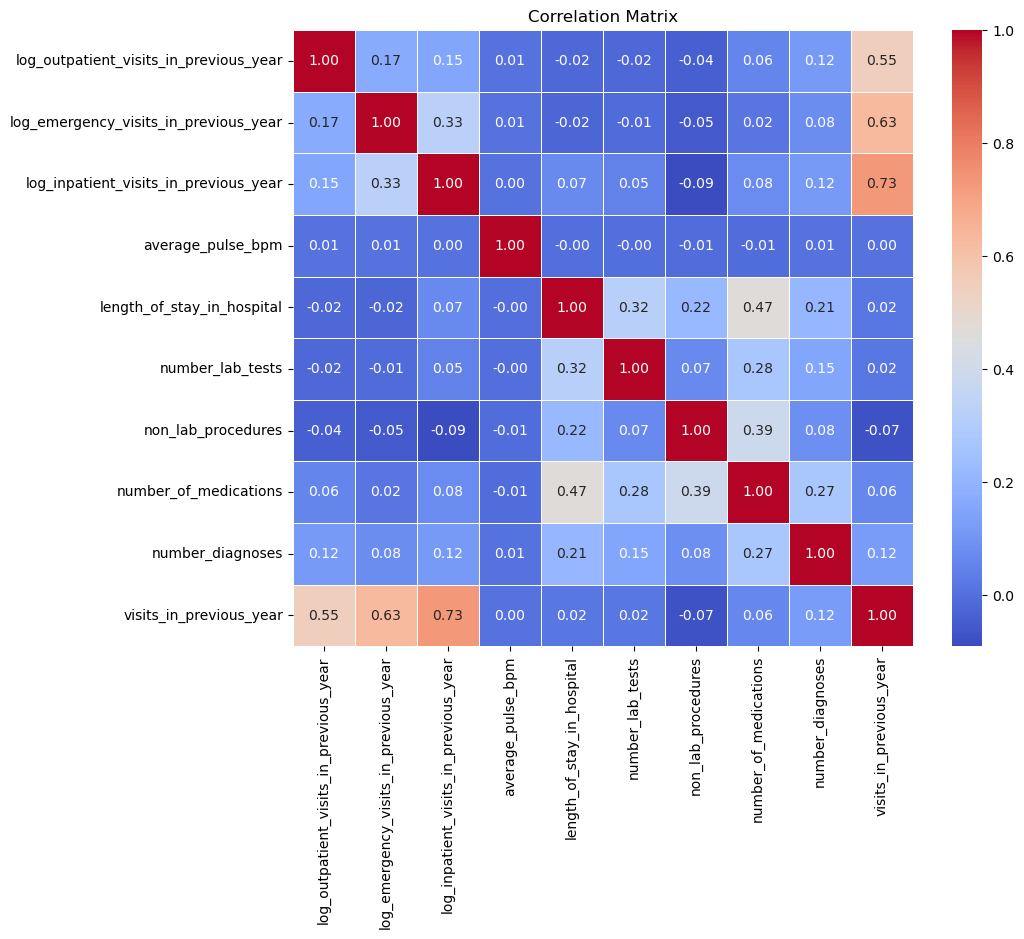

In [148]:
correlation_matrix = X_resampled[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [149]:
high_corr_variables = cor_spearman["readmitted_binary"][abs(cor_spearman["readmitted_binary"]) > 0.75].index.tolist()

# Print or use the high correlation variables
print(high_corr_variables)

['readmitted_binary']


# Wrapper methods - RFE <a class="anchor" id="rfe"></a>

In [150]:
'''
nof_list=np.arange(1,48) # desde 1 até 48 deu 8 features com .score de 0.681530
high_score=0
# Variable to store the optimum features
nof=0
score_list =[]
for i in range(len(nof_list)):
    model = RandomForestClassifier(random_state=42)
    rfe = RFE(model, n_features_to_select=8) # 8 nof_list[i]
    X_train_rfe = rfe.fit_transform(X_resampled, y_resampled)
    X_val_rfe= rfe.transform(X_val)
    model.fit(X_train_rfe,y_resampled)

    score = model.score(X_val_rfe,y_val)
    score_list.append(score)

    if(score>high_score):
        high_score = score
        nof = nof_list[i]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

rfe = RFE(RandomForestClassifier(random_state=42), n_features_to_select=8) # not
X_train_rfe = rfe.fit_transform(X_resampled, y_resampled)
model.fit(X_train_rfe,y_resampled)

rfe_selected_features = pd.Series(rfe.support_, index=X_resampled.columns)
print(rfe_selected_features)
'''

'\nnof_list=np.arange(1,48) # desde 1 até 48 deu 8 features com .score de 0.681530\nhigh_score=0\n# Variable to store the optimum features\nnof=0\nscore_list =[]\nfor i in range(len(nof_list)):\n    model = RandomForestClassifier(random_state=42)\n    rfe = RFE(model, n_features_to_select=8) # 8 nof_list[i]\n    X_train_rfe = rfe.fit_transform(X_resampled, y_resampled)\n    X_val_rfe= rfe.transform(X_val)\n    model.fit(X_train_rfe,y_resampled)\n\n    score = model.score(X_val_rfe,y_val)\n    score_list.append(score)\n\n    if(score>high_score):\n        high_score = score\n        nof = nof_list[i]\n\nprint("Optimum number of features: %d" %nof)\nprint("Score with %d features: %f" % (nof, high_score))\n\nrfe = RFE(RandomForestClassifier(random_state=42), n_features_to_select=8) # not\nX_train_rfe = rfe.fit_transform(X_resampled, y_resampled)\nmodel.fit(X_train_rfe,y_resampled)\n\nrfe_selected_features = pd.Series(rfe.support_, index=X_resampled.columns)\nprint(rfe_selected_features)\n

In [ ]:
rfe_selected_features = ["average_pulse_bpm",'length_of_stay_in_hospital','number_lab_tests','number_of_medications','primary_diagnosis',
                        'secondary_diagnosis','additional_diagnosis',"regular_patient"]

In [ ]:
#rfe_selected_features = rfe_selected_features[rfe_selected_features==True].index.tolist()

# Embedded methods - Lasso <a class="anchor" id="lasso"></a>

In [151]:
sns.set(style="whitegrid")
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.savefig(name+'_plot_importance.png', dpi=200)
    plt.show()

In [152]:
# Baseline dataset (X_train + Y_train)
reg = LassoCV(random_state=42)
reg.fit(X_resampled, y_resampled)
coef = pd.Series(reg.coef_, index = X_resampled.columns)
print(coef.sort_values())

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
# The variables with the value 0 are supposedly dropped.
lasso_selected_features = coef[coef!=0].index.tolist()

payer_code                                  -0.070627
log_outpatient_visits_in_previous_year      -0.061863
medication_nateglinide                      -0.043180
medication_metformin                        -0.033249
primary_diagnosis                           -0.028823
medication_rosiglitazone                    -0.017291
test_result                                 -0.016333
medication_chlorpropamide                   -0.015050
medication_acarbose                         -0.014117
medication_glimepiride                      -0.014018
secondary_diagnosis                         -0.011813
medication_glyburide                        -0.007353
gender_bin                                  -0.005011
medication_insulin                          -0.004553
medication_glipizide                        -0.002951
medication_pioglitazone                     -0.002448
additional_diagnosis                        -0.000312
medication_glimepiride-pioglitazone          0.000000
medication_acetohexamide    

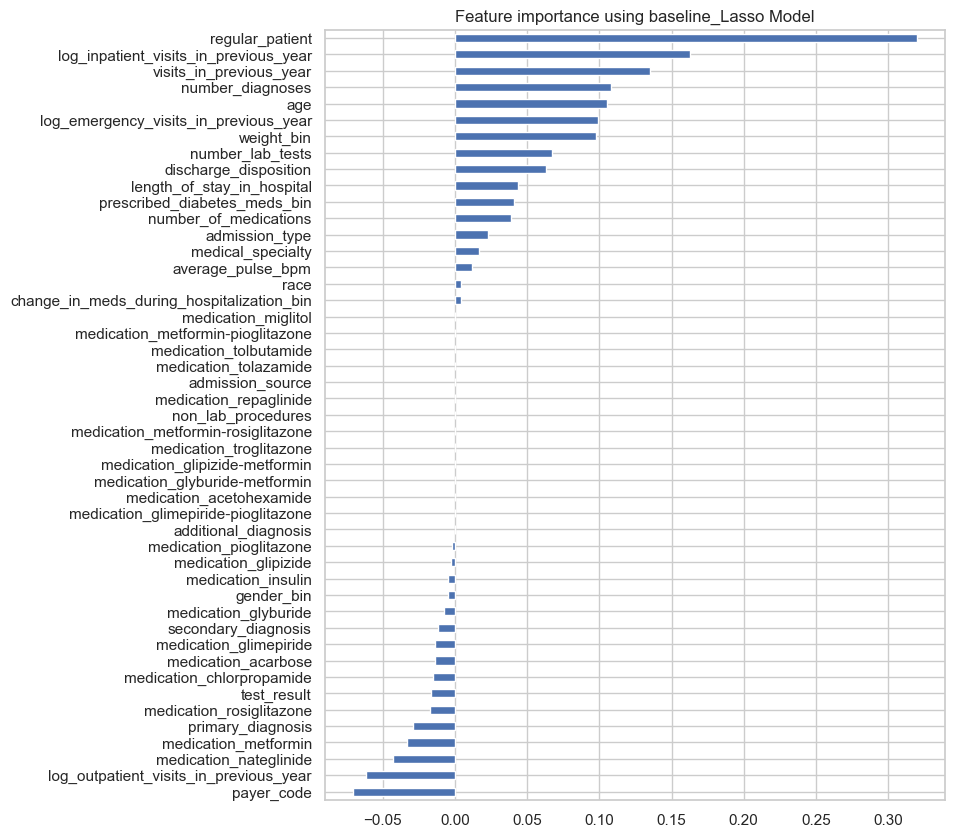

In [180]:
plot_importance(coef,'baseline_Lasso')

# Embedded methods - DecisionTree <a class="anchor" id="dt"></a>

<Axes: xlabel='Value', ylabel='Col'>

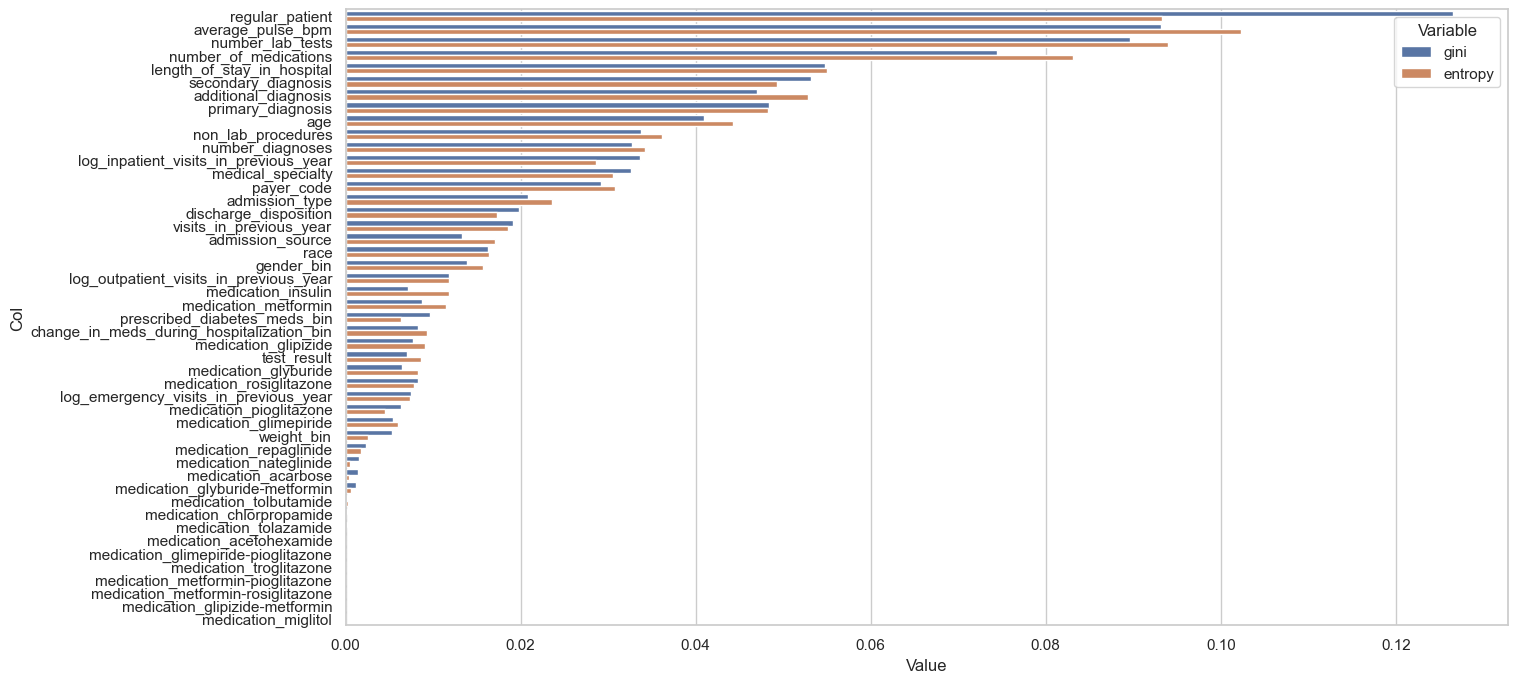

In [156]:
sns.set(style="whitegrid")

gini_importance = DecisionTreeClassifier().fit(X_resampled, y_resampled).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_resampled, y_resampled).feature_importances_

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_resampled.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [157]:
# Decidimos criar um threshold de 47 featues sobre 100 ( recomendação do prof )

selected_features_gini = []
selected_features_entropy = []
print("For GINI INDEX")
association_dict = dict(zip(gini_importance, X_train.columns))
for column, value in association_dict.items():
    if column > (100/47)/100:
        print(f"{column}: {value}")
        selected_features_gini.append(value)

print("-----------------------\n")
print("For ENTROPY IMPORTANCE")
association_dict_e = dict(zip(entropy_importance, X_train.columns))
for column, value in association_dict_e.items():
    if column > (100/47)/100:
        print(f"{column}: {value}")
        selected_features_entropy.append(value)

print("-----------------------\n")
print(set(selected_features_gini).intersection(set(selected_features_entropy)))
print(len(set(selected_features_gini).intersection(set(selected_features_entropy))))


For GINI INDEX
0.04096046700624028: age
0.029199656984591257: payer_code
0.032561394049075425: medical_specialty
0.09321062856994343: average_pulse_bpm
0.054749719514971644: length_of_stay_in_hospital
0.08964942524374703: number_lab_tests
0.03371563452329401: non_lab_procedures
0.0744614085224822: number_of_medications
0.04837438859506503: primary_diagnosis
0.053132249874789345: secondary_diagnosis
0.04705717951802227: additional_diagnosis
0.032684154500677506: number_diagnoses
0.03359907689235946: log_inpatient_visits_in_previous_year
0.12648573204928107: regular_patient
-----------------------

For ENTROPY IMPORTANCE
0.044265468382229355: age
0.03081485146151735: payer_code
0.023606221422487632: admission_type
0.030553412513105577: medical_specialty
0.1022556902418973: average_pulse_bpm
0.055013219245602124: length_of_stay_in_hospital
0.09400682569191174: number_lab_tests
0.03621241690631456: non_lab_procedures
0.08311843101229262: number_of_medications
0.04832565533363648: primary_d

In [158]:
dt_selected_features = set(selected_features_gini).intersection(set(selected_features_entropy))

### Best Feature Selection ( intersection between all methods )

In [159]:
final_features = []

for i in lasso_selected_features:
    #print(i)
    final_features.append(i)
for i in rfe_selected_features:
    #print(i)
    final_features.append(i)
for i in dt_selected_features:
    #print(i)
    final_features.append(i)


In [160]:
feature_counts = Counter(final_features)

final_selected_features = [feature for feature, count in feature_counts.items() if count > 1]

print(final_selected_features)
print(len(final_selected_features))

['age', 'payer_code', 'medical_specialty', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'number_of_medications', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses', 'log_inpatient_visits_in_previous_year', 'regular_patient']
13


In [161]:
metric_final_selected_features = ["age", 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests','number_of_medications','number_diagnoses',
'log_inpatient_visits_in_previous_year']
categorical_final_selected_features = [feature for feature in final_selected_features if feature not in metric_final_selected_features]

print(categorical_final_selected_features)

['payer_code', 'medical_specialty', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'regular_patient']


In [162]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

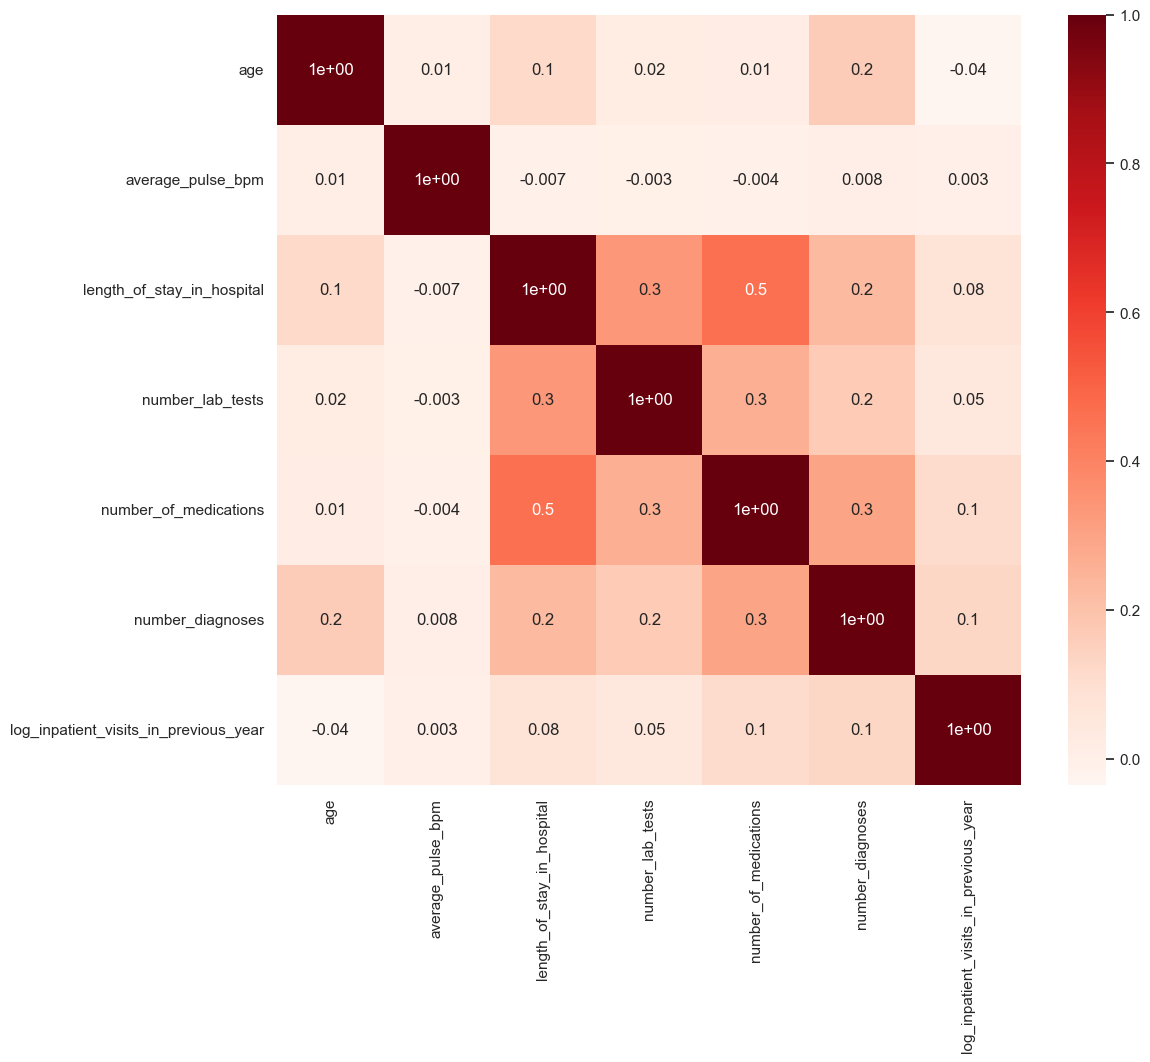

In [163]:
cor_heatmap(X_resampled[metric_final_selected_features].corr(method="spearman"))

In [164]:
X_resampled = X_resampled[final_selected_features]

In [165]:
test = test[final_selected_features]

# Modeling Selection and Evaluation <a class="anchor" id="model_selection"></a>

In [166]:
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

models = ['LogisticReg', 'KNN', 'DecisionTree', 'SVM', 'NaiveBayes', 'BaggingClassifier', 'RandomForest', 'AdaBoost', 'GradBoost',  'MLP']

models_train_score = {}
models_val_score = {}

features_dict = {}

for feat in X_resampled.columns:
  features_dict[feat] = []

for model in models:
  models_train_score[model] = []
  models_val_score[model] = []


for train_index, val_index in rkf.split(X_resampled, y_resampled):

  X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
  y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

# Logistic Regression
  logistic_clf = LogisticRegression(C = 10, random_state=42).fit(X_train, y_train)
  y_pred = logistic_clf.predict(X_train)
  models_train_score['LogisticReg'].append(f1_score(y_train, y_pred))

  y_pred = logistic_clf.predict(X_val)
  models_val_score['LogisticReg'].append(f1_score(y_val, y_pred))


  # KNN
  KNN_clf = KNeighborsClassifier().fit(X_train, y_train) # USAR SÓ METRIC FEATURES
  y_pred = KNN_clf.predict(X_train)
  models_train_score['KNN'].append(f1_score(y_train, y_pred))

  y_pred = KNN_clf.predict(X_val)
  models_val_score['KNN'].append(f1_score(y_val, y_pred))

  # Decision Tree
  tree_clf = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)
  y_pred = tree_clf.predict(X_train)
  models_train_score['DecisionTree'].append(f1_score(y_train, y_pred))

  y_pred = tree_clf.predict(X_val)
  models_val_score['DecisionTree'].append(f1_score(y_val, y_pred))

  # SVM
  svm_clf = SVC(random_state = 42).fit(X_train, y_train)
  y_pred = svm_clf.predict(X_train)
  models_train_score['SVM'].append(f1_score(y_train, y_pred))

  y_pred = svm_clf.predict(X_val)
  models_val_score['SVM'].append(f1_score(y_val, y_pred))

  # GaussianNB
  nb_clf = GaussianNB().fit(X_train, y_train)
  y_pred = nb_clf.predict(X_train)
  models_train_score['NaiveBayes'].append(f1_score(y_train, y_pred))

  y_pred = nb_clf.predict(X_val)
  models_val_score['NaiveBayes'].append(f1_score(y_val, y_pred))

  # BaggingClassifier
  bagging_clf = BaggingClassifier(random_state = 42).fit(X_train, y_train)
  y_pred = bagging_clf.predict(X_train)
  models_train_score['BaggingClassifier'].append(f1_score(y_train, y_pred))

  y_pred = bagging_clf.predict(X_val)
  models_val_score['BaggingClassifier'].append(f1_score(y_val, y_pred))

  # Random Forest
  forest_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
  y_pred = forest_clf.predict(X_train)
  models_train_score['RandomForest'].append(f1_score(y_train, y_pred))

  y_pred = forest_clf.predict(X_val)
  models_val_score['RandomForest'].append(f1_score(y_val, y_pred))

  # Adaptive Boosting with Decision Tree
  adaboost_clf = AdaBoostClassifier(random_state = 42).fit(X_train, y_train)
  y_pred = adaboost_clf.predict(X_train)
  models_train_score['AdaBoost'].append(f1_score(y_train, y_pred))

  y_pred = adaboost_clf.predict(X_val)
  models_val_score['AdaBoost'].append(f1_score(y_val, y_pred))

  # Gradient Boosting
  grad_clf = GradientBoostingClassifier(random_state = 42).fit(X_train, y_train)
  y_pred = grad_clf.predict(X_train)
  models_train_score['GradBoost'].append(f1_score(y_train, y_pred))

  y_pred = grad_clf.predict(X_val)
  models_val_score['GradBoost'].append(f1_score(y_val, y_pred))

  # MLP
  mlp_clf = MLPClassifier(hidden_layer_sizes = (100, 100, 100), random_state = 42).fit(X_train, y_train)
  y_pred = mlp_clf.predict(X_train)
  models_train_score['MLP'].append(f1_score(y_train, y_pred))

  y_pred = mlp_clf.predict(X_val)
  models_val_score['MLP'].append(f1_score(y_val, y_pred))

In [167]:
def show_models_results(train_scores, val_scores):
  df = pd.DataFrame(columns = ['Train', 'Val'], index = train_scores.keys())

  for model, scores in train_scores.items():
    df.loc[model, 'Train'] = str(round(np.mean(train_scores[model]),3)) + '+/-' + str(round(np.std(train_scores[model]),2))
    df.loc[model, 'Val'] = str(round(np.mean(val_scores[model]),3)) + '+/-' + str(round(np.std(val_scores[model]),2))

  return df

In [168]:
df = show_models_results(models_train_score, models_val_score)

df

,Train,Val
LogisticReg,0.684+/-0.0,0.684+/-0.01
KNN,0.748+/-0.0,0.628+/-0.01
DecisionTree,1.0+/-0.0,0.584+/-0.01
SVM,0.704+/-0.0,0.702+/-0.01
NaiveBayes,0.663+/-0.0,0.662+/-0.01
BaggingClassifier,0.982+/-0.0,0.609+/-0.01
RandomForest,1.0+/-0.0,0.688+/-0.01
AdaBoost,0.685+/-0.0,0.683+/-0.01
GradBoost,0.714+/-0.0,0.706+/-0.01
MLP,0.879+/-0.01,0.617+/-0.01


# Models Fine Tuning <a class="anchor" id="finetuning"></a>

### Logistic Regression <a class="anchor" id="lr"></a>

In [169]:
'''
LR = LogisticRegression()
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['None', 'l2'],
    'solver': ['lbfgs', 'saga']
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, cv=10, scoring = 'f1')

# fitting the model for grid search
LR_search.fit(X_train , y_train)
LR_search.best_params_
'''

"\nLR = LogisticRegression()\nLRparam_grid = {\n    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],\n    'penalty': ['None', 'l2'],\n    'solver': ['lbfgs', 'saga']\n}\nLR_search = GridSearchCV(LR, param_grid=LRparam_grid, cv=10, scoring = 'f1')\n\n# fitting the model for grid search\nLR_search.fit(X_train , y_train)\nLR_search.best_params_\n"

In [170]:
# Create the model
log_reg2 = LogisticRegression(C = 10, penalty = 'l2', solver = 'lbfgs', random_state=42)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# create a splitter object
kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

log_reg2 = LogisticRegression()

scoring_metrics = ["accuracy", "recall", "precision", "f1"]
#for score in ["accuracy", "recall", "precision", "f1"]:
cv_score = cross_validate(log_reg2,
                            X_resampled, y_resampled,
                            cv=kfold,
                            scoring=scoring_metrics)

  #print(f"{score}: {cv_score.mean()}")
for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")

accuracy: 0.6765094339622642
recall: 0.6992892888203509
precision: 0.6688615869123657
f1: 0.683686376310887


### GradientBoostingClassifier <a class="anchor" id="gb"></a>

In [171]:
'''
gradient_boost = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(gradient_boost, param_distributions=param_dist, n_iter=20, cv=5, scoring='f1', random_state=42, verbose=2)
random_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
'''

'\ngradient_boost = GradientBoostingClassifier(random_state=42)\n\nparam_dist = {\n    \'n_estimators\': randint(50, 200),\n    \'learning_rate\': uniform(0.01, 0.1),\n    \'max_depth\': randint(3, 10),\n    \'min_samples_split\': randint(2, 20),\n    \'min_samples_leaf\': randint(1, 10),\n    \'subsample\': uniform(0.5, 0.5)\n}\n\nrandom_search = RandomizedSearchCV(gradient_boost, param_distributions=param_dist, n_iter=20, cv=5, scoring=\'f1\', random_state=42, verbose=2)\nrandom_search.fit(X_resampled, y_resampled)\n\n# Print the best hyperparameters\nprint("Best Hyperparameters:", random_search.best_params_)\n'

In [172]:
gbc = GradientBoostingClassifier(n_estimators=93, learning_rate=0.06200680211778108, max_depth=4, random_state=42, min_samples_split=19, subsample=0.9697494707820946)


# create a splitter object
kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


scoring_metrics = ["accuracy", "recall", "precision", "f1"]
cv_score = cross_validate(gbc,
                            X_resampled, y_resampled,
                            cv=kfold,
                            scoring=scoring_metrics)

for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")

accuracy: 0.6866037735849057
recall: 0.7519024751208445
precision: 0.6650461239563099
f1: 0.7057861833948734


### RandomForest <a class="anchor" id="rf"></a>

In [173]:
'''
# Define the parameter grid
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # Adjust the number of iterations as needed
    cv=5,       # Adjust the number of cross-validation folds as needed
    scoring='f1',  # Use an appropriate scoring metric
    random_state=42,
    verbose=3
)

# Perform the Randomized Search on your data
random_search.fit(X_resampled, y_resampled)

# Get the best parameters
best_params = random_search.best_params_

# Print the best parameters
print("Best Hyperparameters:", best_params)
'''

'\n# Define the parameter grid\nparam_dist = {\n    \'n_estimators\': randint(10, 200),\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\', None],\n    \'max_depth\': randint(1, 20),\n    \'min_samples_split\': randint(2, 20),\n    \'min_samples_leaf\': randint(1, 20),\n    \'bootstrap\': [True, False]\n}\n\n# Create a Random Forest classifier\nrf = RandomForestClassifier()\n\n# Create a RandomizedSearchCV object\nrandom_search = RandomizedSearchCV(\n    estimator=rf,\n    param_distributions=param_dist,\n    n_iter=30,  # Adjust the number of iterations as needed\n    cv=5,       # Adjust the number of cross-validation folds as needed\n    scoring=\'f1\',  # Use an appropriate scoring metric\n    random_state=42,\n    verbose=3\n)\n\n# Perform the Randomized Search on your data\nrandom_search.fit(X_resampled, y_resampled)\n\n# Get the best parameters\nbest_params = random_search.best_params_\n\n# Print the best parameters\nprint("Best Hyperparameters:", best_params)\n'

In [174]:
# Create a RandomForestClassifier with the best hyperparameters
# best_rf_model = RandomForestClassifier(**best_params)

In [175]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=2, min_samples_split=10, min_samples_leaf=1)

kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


scoring_metrics = ["accuracy", "recall", "precision", "f1"]
cv_score = cross_validate(rf_model,
                            X_resampled, y_resampled,
                            cv=kfold,
                            scoring=scoring_metrics)

for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")

accuracy: 0.6801886792452831
recall: 0.7167581697748495
precision: 0.6679500069625319
f1: 0.6914552012530949


### SVC <a class="anchor" id="svc"></a>

In [176]:
'''
# Define the parameter grid
param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create an SVC classifier
svc_classifier = SVC()

# Perform grid search using cross-validation
random_search = RandomizedSearchCV(svc_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1', n_jobs=-1, random_state=42)
random_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
'''

'\n# Define the parameter grid\nparam_dist = {\n    \'C\': uniform(0.1, 10),\n    \'kernel\': [\'linear\', \'rbf\', \'poly\'],\n    \'gamma\': [\'scale\', \'auto\', 0.1, 1]\n}\n\n# Create an SVC classifier\nsvc_classifier = SVC()\n\n# Perform grid search using cross-validation\nrandom_search = RandomizedSearchCV(svc_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring=\'f1\', n_jobs=-1, random_state=42)\nrandom_search.fit(X_resampled, y_resampled)\n\n# Print the best hyperparameters\nprint("Best Hyperparameters:", random_search.best_params_)\n'

In [177]:
svc_classifier = SVC(C= 5.347746602583891, gamma= 0.1, kernel = 'rbf', random_state=42)

kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


scoring_metrics = ["accuracy", "recall", "precision", "f1"]
cv_score = cross_validate(svc_classifier,
                            X_resampled, y_resampled,
                            cv=kfold,
                            scoring=scoring_metrics)

for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")

accuracy: 0.6868553459119496
recall: 0.7447955097212364
precision: 0.6674419365611254
f1: 0.7039745474882859


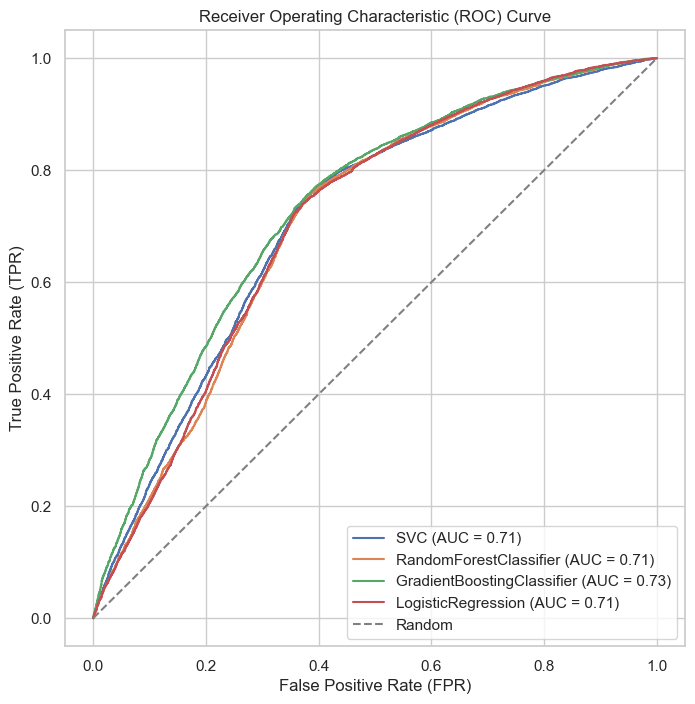

In [178]:
classifiers = [svc_classifier, rf_model, gbc, log_reg2]

def plot_roc_curve(classifier, X, y, name):
    try:
        y_scores = cross_val_predict(classifier, X, y, cv=5, method="predict_proba")[:, 1]
    except AttributeError:
        try:
            y_scores = cross_val_predict(classifier, X, y, cv=5, method="decision_function")
        except AttributeError:
            y_scores = cross_val_predict(classifier, X, y, cv=5, method="predict_log_proba")[:, 1]

    fpr, tpr, thresholds = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curves for each classifier
plt.figure(figsize=(8, 8))

for classifier in classifiers:
    plot_roc_curve(classifier, X_resampled, y_resampled, classifier.__class__.__name__)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Voting Classifier <a class="anchor" id="VC"></a>

In [179]:
ensemble_classifier = VotingClassifier(
    estimators=[('gbc', gbc), ('lr', log_reg2)],
    voting='soft'  
)


kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

scoring_metrics = ["accuracy", "recall", "precision", "f1"]

cv_score = cross_validate(
    ensemble_classifier,
    X_resampled,
    y_resampled,
    cv=kfold,
    scoring=scoring_metrics
)

for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")

accuracy: 0.6845283018867925
recall: 0.730398037372886
precision: 0.66901752571
f1: 0.6983371352780303


# Predictions for the test data <a class="anchor" id="testpredictions"></a>

In [192]:
ensemble_classifier.fit(X_resampled, y_resampled)
y_pred_test = ensemble_classifier.predict(test)
sub = pd.Series(y_pred_test, index = test.index)
sub = sub.map({0: 'No', 1: 'Yes'})
sub.columns = ["readmitted_binary"]
sub.to_csv("final_out1.csv")

sub

encounter_id
499502    Yes
447319    Yes
309126    Yes
181183    Yes
359339    Yes
         ... 
451150    Yes
549298    Yes
327586    Yes
351214    Yes
914270    Yes
Length: 30530, dtype: object